##  Classifying audio data with convolutional neural networks

<br/>
by Eduardo Garcia Rajo<br/>
<br/>

This notebook is part of the project "Urban sounds classification with Covnolutional Neural Networks" on [my Github](https://github.com/GorillaBus/urban-audio-classifier).<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

# Data pre-processing

In this second notebook we are going to review the different approaches to feed a neural network with digital audio data. Then evaluate how to convert our audio files to a common format to ensure we are working with normalized data. Then we'll discuss on feature extraction techniques, as we are not going to work directly with raw audio.<br/>
<br/>

Index:
1. Different approaches
2. Standarisation of digital audio
3. Feature extraction
4. Next

#### * Setup
Pay attention to the very simple path variables configured in this section.

In [1]:
# Required libraries
import sys
import os
import IPython as IP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pickle
from include import helpers

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [15]:
# Set your path to the dataset
us8k_path = './data/UrbanSound8k'
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')

./data/UrbanSound8k\audio


#### * Load metadata

In [4]:
# Load the metadata from the generated CSV
metadata = pd.read_csv(metadata_path)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


## 1. Different approaches

There are many ways in which you can feed a network from digital audio data, most of them have already been experimented already with different results.<br/> 
To understand this approaches is better to understand first how audio data differentiates from visual data: one aspect of audio data comes from the fact that sound is serial; it is digitally saved as sequences of "frames" containing audio information for a fraction of time. A particular sound event is described by many continuous frames, each frame will hold information about frequencies, amplitudes and other audio characteristics. <br/>
Another important aspect is how sound events accumulate: on images you can recognize and separate different discrete visual objects (a chair, a cat, an acoustic guitar). But different discrete sound events will share frequencies, and thus, a discrete sound event is not separable from another, they all sum together into a distinct whole.<br/>
In conclusion, although our brain is very well trained to differentiate sound sources, producing a model that to differentiate specific sound events is not as "direct" as recognizing particular visual objects in an image.<br/>
<br/>
Different approaches in sound recognition with neural networks (and other predictive architectures like SVM) had been researched in the last years, this are some of the more relevant:<br/>
<br/>

#### 1.1 Serial audio data

This is the most simple approach where you feed a MLP (Muli-Layered Perceptron) network directly with serial audio data. It has been proven that the network is capable of learning patterns for sound recognition with this approach, but the results are not optimal.<br/>
<br/>

#### 1.2 Spectrograms

A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. The interesting aspect of this approach is that you can treat audio signals as images, and thus, use it to feed a 2-dimensional convolutional layer: directly, by using the image of a spectrogram or (usually better) using the coefficients values that describe a spectrogram.<br/>
<br/>
The drawback is that a spectrogram is spectrograms use a linear frequency scaling, so each frequency bin is spaced the equal number of Hertz apart. This is not how the human auditory system work, our brain tends to separate sound components in a logarithmic scale, so the normal spectrogram does not represent sound exactly as we listen to it.<br/>
<br/>
To build up a spectrogram, a windowing function is applied to each audio frame, then the Short-Term Fourier Transform (STFT) is computed on each frame, finally the power spectrum and filter banks are computed. Luckily, libraries like LibROSA offer a very simplified interface to this process.<br/>
<br/>
This is a spectrogram of a random file in the dataset:

./data/UrbanSound8k\audio/fold4/22883-7-47-2.wav


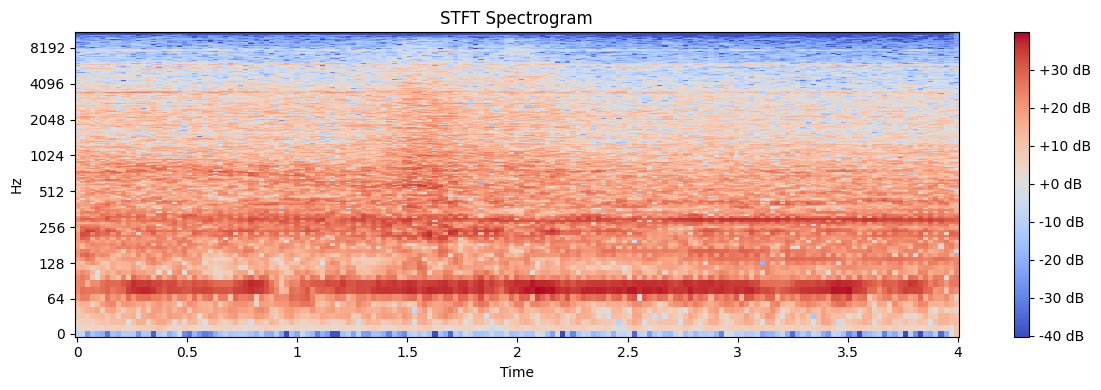

In [16]:
# Get a random file
row = metadata.sample(1)
file_path = audio_path + '/fold'+ str(row.iloc[0,5]) +'/' + str(row.iloc[0,0])


# Windowing
n_fft=2048
hop_length=512

# Load audio file
y, sr = librosa.load(file_path)

# Normalize between -1 and 1
normalized_y = librosa.util.normalize(y)

# Compute STFT
stft = librosa.core.stft(normalized_y, n_fft=n_fft, hop_length=hop_length)

# Convert sound intensity to log amplitude:
stft_db = librosa.amplitude_to_db(abs(stft))


# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(stft_db, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB');
plt.title('STFT Spectrogram')
plt.tight_layout()
plt.show()

#### 1.3 Mel-Frequency Cepstral Coefficients (MFCCs)

MFCCs has been the most common approach for the last years as it has proved to perform much better than normal spectrograms. MFCC takes into account human perception for sensitivity at appropriate frequencies by converting the conventional frequency to **Mel Scale** (which is not linear but logarithmic).<br/>
<br/>
To generate MFCCs a Discrete Cosine Transform (DCT) is applied to the filter banks obtained in the last process, retaining a number of the resulting coefficients while the rest are discarded.<br/>
<br/>
This is an MFCC plot from a random audio sample in our dataset:

C:\Users\angel\AppData\Local\Temp\ipykernel_58640\549954135.py:2: FutureWarning: Pass y=[-0.35252342 -0.4432739  -0.22237    ...  0.09513656  0.20475946
  0.19382004], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(normalized_y, sr, n_mfcc=40)


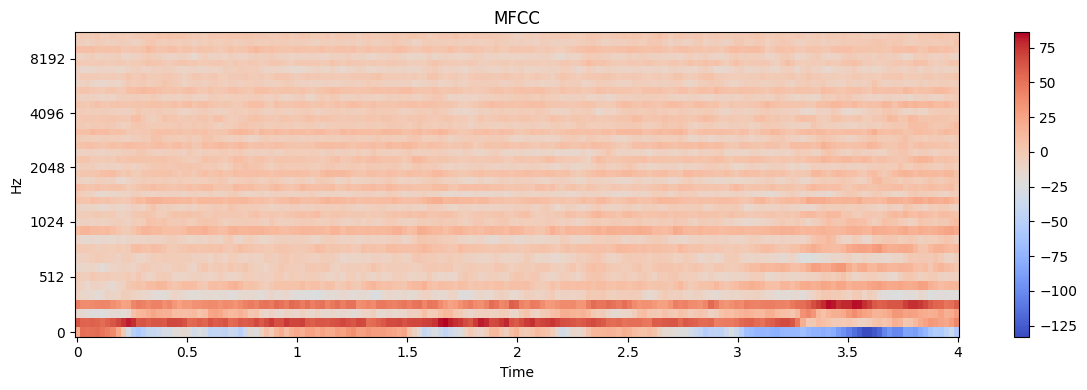

In [6]:
# Generate MFCC coefficients
mfcc = librosa.feature.mfcc(normalized_y, sr, n_mfcc=40)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

#### 1.4 MEL-Scaled filter banks

Although MFCCs work very well, there's still a problem with it: Discrete Cosine Transform (DCT) is used to decorrelate filter bank coefficients (a process referred to as "whitening"). DCT, as a linear transform, will discard some information from the original signal (something we don't really want to happen).<br/>
Whitening was required for models that where more susceptible to highly correlated input (like Gaussian Mixture Models), but as deep neural networks are much less susceptible we could easily eliminate DCT from the pipeline.<br/>
<br/>
Once the filter banks had been computed they are scaled to the MEL scale to obtain the MEL-Scaled filter banks. This is how a MEL Spectrogram looks:

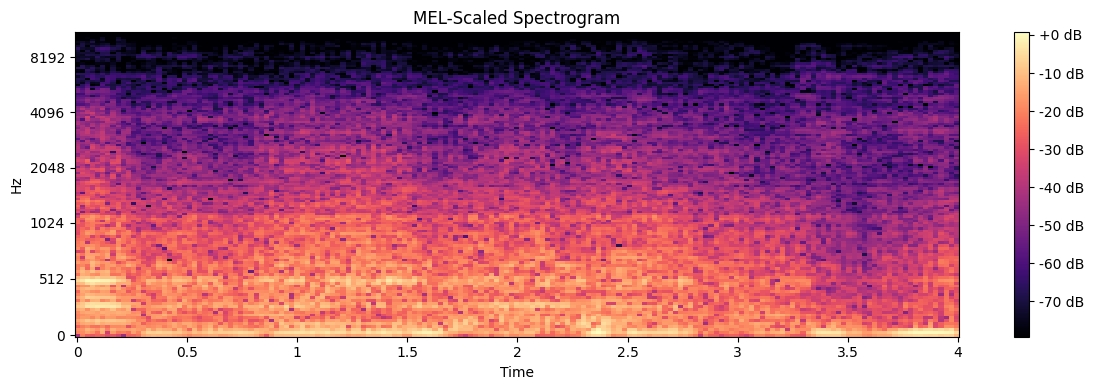

In [7]:
n_mels = 128

# Generate mel scaled spectrogram
mel = librosa.feature.melspectrogram(S=stft, n_mels=n_mels)

# Convert sound intensity to log amplitude:
mel_db = librosa.amplitude_to_db(abs(mel))

# Normalize between -1 and 1
normalized_mel = librosa.util.normalize(mel_db)

# Plot spectrogram from STFT
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');
plt.title('MEL-Scaled Spectrogram')
plt.tight_layout()
plt.show()

#### 1.5 Feature combination

There are reports of very good results by combining different features by concatenation, for example using the ones we already know (MFCC and Log-Mel Spectrogram) with other auditory features like **Chroma**, **Spectral Contrast** and **Tonnetz**.<br/>
At the moment we are only working with single features but a model trained with combined features may be in tested on future updates.<br/>
<br/>

## 2. Standardization of digital audio

As we already discovered during data exploration we have a notable variance between different audio properties (sample rate, bit depth, duration). There are some important considerations we must take care of when working on audio conversion regarding this audio properties:<br/>
<br/>

#### 2.1 Sample Rate
Higher sample rates also mean wider frequency ranges. The higher the sample rate used to record a sound, the more frequencies being captured. More precisely, according to the [Nyquist Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), the highest frequency that can be captured in a recording is equal to the recording sample rate divided by 2. For example, while recording at 48.000 khz only frequencies up to 22.200 khz can be captured. This will also apply to resampling: while a 44.100 khz audio may contain frequencies up to 22.050 khz, when resampled to 22.050 khz the new file will contain half that range: up to 11.025 khz.<br/>
<br/>
Luckily for us, most of the recognizable changes in sound will occur in the lower frequencies and we can downsample to 22.050 khz, preserving most patterns we need our CNN to recognize, and also reducing the volume of data. If you like to learn more in depth I recommend you this [well explained audio sampling article](http://support.ircam.fr/docs/AudioSculpt/3.0/co/Sampling.html).<br/>

However, resampling audio may incur in what is known as Aliasing. To overcome this common problem converters use "Anti Aliasing Filters". It is crucial that we use a conversor with well-implemented filters or the required audio features will be "corrupted" after the process.<br/>
<br/>

#### 2.2 Bit Depth
Different bit depths mean higher resolution but also different scales. Converting bit depths is not problematic as converting sample rate (*see below).<br/>

<br/>

#### 2.3 Max Amplitude 
Each sound file will usually have a different maximum point of amplitude. Ideally, we'd like to normalize this amplitude values to fit the same scale between all samples.<br/>

<br/>

#### 2.4 Duration  
A convolutional neural network requires to be fed with spatially related data. Images are a good example: if you change the order of columns or rows, the position of pixels change and the information does not describe the original image anymore. Similarly, different image sizes imply different spatial configurations.<br/>
<br/>
In sound we have a strict relation between frequencies and amplitudes over time, and having a dataset of varying sound durations means varying input vector sizes to feed our CNN. To overcome this problem we'll use padding: for all the samples of length less than the maximum length in our data collection, we'll fill up space with zeros until we reach that maximum value. This is a commonly used technique and it does not alter the performance of the network.<br/>
<br/>

#### 2.5 Good news
Loading files with LibROSA will automatically convert audio to 22.050 khz and 16 bit with tested quality audio conversion. We can then use the same library to normalize the data values between 0 and 1. Using LibROSA, we just need to load files and we are almost ready to work with the data.<br/>

The only disadvantage of LibROSA, as a native Python library, is it's processing speed: it is much slower to convert and to extract audio features with LibROSA than with ffmpeg or any other C/C++ library. But, on my personal tests between LibROSA and other libraries (like Essentia, a super fast C++ library with Python bindings), the first one achieved higher scores, so, supposing a better algorithm implementation, I decided to sacrifice speed/time for quality.<br/>
<br/>

### 3. Feature extraction

We would like to compare both MFCC and MEL Spectrograms with our models. Functions to extract both features are provided in the helpers include, which are based on the previous code from this notebook.<br/>

#### 3.1 MFCC coefficients extraction

We are extracting 40 coefficients (also referred as bands) per frame. As the frame count is variable we are also adding zero-padding to those samples that do not reach the maximum (padded is added at both sides of the feature).

In [8]:
# Iterate through all audio files and extract MFCC
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(metadata)
n_mfcc = 40

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath(audio_path), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]

    # Extract MFCCs (do not add padding)
    mfccs = helpers.get_mfcc(file_path, 0, n_mfcc)
    
    # Save current frame count
    num_frames = mfccs.shape[1]
    
    # Add row (feature / label)
    features.append(mfccs)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 500):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

Status: 501/8732
Status: 1001/8732


KeyboardInterrupt: 

In [388]:
# Add padding to features with less than frames than frames_max
padded_features = helpers.add_padding(features, frames_max)

In [391]:
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded_features)))
print("Feature labels length: {}".format(len(labels)))

Raw features length: 8732
Padded features length: 8732
Feature labels length: 8732


#### 3.2 Save MFCC features

In [393]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded_features)
y = np.array(labels)

# Optionally save the features to disk
np.save("data/X-mfcc", X)
np.save("data/y-mfcc", y)

#### 3.4 MEL Spectrogram extraction

Let's also extract the MEL Spectrograms to compare performance with both feature types.

In [9]:
# Iterate through all audio files and extract MFCC
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(metadata)
n_mels=40

for index, row in metadata.iterrows():
    file_path = os.path.join(os.path.abspath(audio_path), 'fold' + str(row["fold"]), str(row["slice_file_name"]))
    class_label = row["class"]

    # Extract Log-Mel Spectrograms (do not add padding)
    mels = helpers.get_mel_spectrogram(file_path, 0, n_mels=n_mels)
    
    # Save current frame count
    num_frames = mels.shape[1]
    
    # Add row (feature / label)
    features.append(mels)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 500):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00346737 -0.00514214 -0.00470753 ... -0.00251551 -0.00157867
 -0.00035813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09977774  0.13488662  0.08467971 ... -0.2804235  -0.16797534
  0.03390469] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16558747 -0.19027671 -0.09770343 ... -0.07868391 -0.11585506
 -0.12947263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02395494  0.09870885  0.08696914 ... -0.02019365  0.03696162
  0.06668624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.10900718  0.06434362 -0.05181101 ... -0.0649339  -0.05591289
 -0.07512061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0864246   0.04443679 -0.19319928 ... -0.00762564  0.234587
  0.29728967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.         0.         0.         ... 0.00347376 0.10524184 0.09133453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07083678  0.01749695  0.1292643  ... -0.00388218 -0.00041398
 -0.0664399 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0069927   0.04964779  0.04050964 ...  0.04958642 -0.04921229
 -0.16162387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04127589  0.01237607 -0.07127335 ... -0.00480024  0.02084072
  0.00408691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.031975   -0.00170078  0.0343013  ...  0.00366982  0.12444473
 -0.04324995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06849322 -0.04234983  0.12094927 ... -0.0089943  -0.00523917
 -0.01558642] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[5.4611981e-05 1.3516337e-03 2.7450940e-03 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.13153284e-04 -1.76982197e-04 -1.77427035e-04 ...  2.16321975e-01
  2.20865712e-01  2.30278626e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00035138 -0.00012938  0.00152504 ... -0.05678371 -0.06595192
 -0.08217044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.32202786 -0.46902156 -0.38860938 ...  0.01414551  0.07173594
  0.09408636] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.42217842 -0.61124456 -0.53770226 ...  0.5772664   0.58414507
  0.6515601 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00245041  0.04510117  0.0393945  ...  0.2812495   0.2640951
  0.3383592 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.2685922  -0.3811571  -0.28766882 ... -0.05742895  0.15544619
  0.37846994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01469073 0.08501469 0.14074682 ... 0.400362   0.28594628 0.1694335 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02430845  0.06302236  0.17463648 ...  0.03587589  0.0771108
  0.06626502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09229512  0.07161381  0.05511004 ... -0.02165085 -0.00238894
  0.05847869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.29220486  0.27342942  0.2189622  ... -0.01151225  0.0035936
 -0.31455556] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08660155 -0.20683594 -0.33823    ... -0.03418105 -0.06052281
 -0.04100648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.02303901  0.06641122
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.16799322  0.22415979  0.03412579 ...  0.03137491  0.03081048
 -0.00842427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[1.1041710e-04 1.2579135e-03 2.7465909e-03 ... 2.5493914e-01 2.3281525e-01
 2.2380807e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07699416 -0.14272526 -0.1474842  ... -0.23809256 -0.25491098
 -0.23043312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12892193 -0.16515957 -0.11778089 ... -0.04328653 -0.04554054
 -0.03480618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11492842 -0.14417626 -0.10623223 ...  0.30213958  0.25849372
  0.23887332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01382027 -0.0401401  -0.00328005 ... -0.10477004 -0.08726571
 -0.04191736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06120085  0.1103568   0.07689846 ... -0.0390107  -0.00414677
 -0.02746483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14197864 -0.22970775 -0.18448503 ...  0.06492887 -0.03231321
 -0.0950878 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03006113  0.05925553  0.02346365 ... -0.00765953 -0.00667248
 -0.0013251 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01020597 0.06261964 0.07517537 ... 0.04055884 0.05070811 0.2120034 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00698861 0.01049649 0.01020098 ... 0.2755642  0.18314673 0.35900533] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03572453 -0.10814565 -0.06821542 ... -0.00304122  0.04210365
  0.01684657] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07724332  0.2360617   0.16540577 ...  0.01055872  0.02607189
 -0.01335062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02059427 -0.00620708  0.02114028 ... -0.04000483 -0.02531435
 -0.01817082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00859988 -0.00207039  0.01550749 ... -0.0348547   0.1053464
  0.09026716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03349348  0.10982228 -0.00446513 ...  0.00174818  0.0060954
  0.00676026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12394831 -0.04636414  0.1340482  ... -0.0472968  -0.05525924
 -0.01550806] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04532586 -0.03738291  0.00330346 ... -0.04941621 -0.0145565
  0.00391403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02079758  0.0308196  -0.00127839 ... -0.00558229 -0.00408827
 -0.00355928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00419721 -0.00601351 -0.00404291 ... -0.00353883 -0.01545586
  0.006009  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.25586793  0.2273233   0.05422701 ... -0.05895045 -0.00565967
  0.0324526 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00402073  0.01596649  0.00928964 ...  0.02190857 -0.13162017
  0.05074381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00545583 -0.01560147  0.00499667 ... -0.01204874 -0.0084839
 -0.05204364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.12391865 0.17389882 0.10311057 ... 0.40521324 0.4052762  0.3299868 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1244809  -0.25145194 -0.27365595 ...  0.3194668   0.3174277
  0.2960577 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00273504 -0.01727573 -0.04023479 ...  0.06579423  0.18142301
  0.07468986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05910651 -0.09588141 -0.08031534 ... -0.02540195 -0.01741509
 -0.01442113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05363815 -0.08268732 -0.07926794 ...  0.15272114  0.19190384
  0.25411   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.12067485  0.11244851 -0.03880875 ... -0.02338484 -0.0284887
 -0.04447467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02232238 -0.02760378 -0.00404878 ...  0.3054198   0.28988594
  0.29723147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.10910787 0.18234399 0.16821109 ... 0.2042127  0.17724216 0.15895046] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.23279622  0.3579863   0.30647203 ... -0.2451948  -0.2505846
 -0.29030555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

Status: 501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00537161  0.00127966  0.00903769 ... -0.02112823 -0.00857961
  0.00702085] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03269367 0.04197723 0.0329091  ... 0.01126679 0.07101509 0.08721983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00297797 -0.00481628 -0.01453912 ...  0.04045389  0.03965148
  0.05095153] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05620636 0.11628743 0.12095916 ... 0.4270045  0.48553506 0.521513  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00300029  0.00714394  0.00439088 ...  0.18597838  0.15271565
  0.14244765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.18268451  0.28425932  0.27500212 ... -0.233598   -0.19527367
 -0.18728864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.15545006  0.20401742  0.18014246 ... -0.38266557 -0.38749808
 -0.40804857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0451186  -0.10128574 -0.04013793 ...  0.13918115  0.14152667
  0.11509789] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1855485  -0.26159126 -0.2429047  ...  0.02022834  0.02416717
  0.03770698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16248468 -0.23886156 -0.17286032 ...  0.00055628 -0.01182318
  0.0618944 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.13956527 -0.24126792 -0.21993019 ...  0.16728158  0.0967397
 -0.0948761 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01434091 0.0227927  0.02089377 ... 0.33847782 0.2884651  0.2688218 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 3.1312643e-06  5.8375175e-05  1.0049533e-04 ... -1.9058390e-02
 -1.2622616e-01 -7.4862443e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.19866504 0.25418118 0.04119378 ... 0.21432143 0.15192734 0.22499904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.15570155 -0.05464746 -0.1338983  ...  0.02533926  0.01966362
 -0.08682603] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\i

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1670546  -0.28549635 -0.18037382 ... -0.10663483  0.04666216
  0.21753268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.33892736 -0.35177723 -0.2072083  ...  0.08126019 -0.01445093
 -0.05482941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.14481078 0.255387   0.12699851 ... 0.3778765  0.40358585 0.45297936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02672689 -0.02817247 -0.07989229 ... -0.11809173 -0.06762531
 -0.00125859] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.13015702  0.22764422  0.23590475 ... -0.25305817 -0.39681146
 -0.5890717 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03292077  0.11027554  0.15642947 ...  0.0531755  -0.00179287
 -0.02261028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.5425096  -0.9912514  -0.88223493 ... -0.3146982  -0.33189222
 -0.40740696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.13118136 -0.25010177 -0.24407719 ... -0.4391387  -0.40345815
 -0.46130222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.24636309 -0.48162207 -0.45359707 ... -0.25365394 -0.21584262
 -0.19288248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06227378 -0.09200618 -0.05980412 ... -0.1359185  -0.12719585
 -0.16433921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08718941 -0.14483967 -0.12138972 ...  0.0359843   0.03441288
  0.03475791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10290295 -0.19399719 -0.18800953 ... -0.0742568  -0.05507537
 -0.06571896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08174633 -0.1620538  -0.16188727 ...  0.38241234  0.3793969
  0.42166913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.49632394 -0.8952762  -0.7786045  ...  0.69737226  0.6601477
  0.72466576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.21407607 -0.3910178  -0.34114787 ... -0.28453118 -0.26558563
 -0.28169745] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00154439 -0.00771632 -0.00915519 ... -0.00195925  0.00033648
 -0.00176151] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00149267 -0.00237908 -0.00396662 ...  0.00022419  0.00013716
 -0.00061942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-2.4893856e-05  2.2008298e-05  1.2535787e-05 ...  1.1231404e-02
  9.8457886e-03  1.0272912e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05034934  0.05788146  0.05956366 ... -0.00709373 -0.04762492
 -0.06186385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 2.8978050e-06  7.7269524e-06  8.4824569e-05 ... -3.3604763e-02
 -2.4011543e-02 -7.6637133e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07301164  0.05676937 -0.0079684  ...  0.30710697  0.3367035
  0.3667482 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\t

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05140293  0.07256093  0.02805677 ... -0.0231604  -0.01584231
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00101314  0.00105408  0.00075851 ... -0.29322144 -0.2582598
 -0.24805062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00411296 -0.0060011  -0.00459578 ... -0.00028909 -0.0006037
 -0.00104699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01107024  0.0150825   0.01837573 ... -0.07823387 -0.1253813
 -0.16137567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05311071  0.122137    0.11970337 ... -0.00160699  0.00587045
 -0.00384456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07362221 -0.12078299 -0.11935754 ... -0.02984514 -0.03052578
 -0.04695895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05252939  0.07789163  0.06974385 ... -0.18112363 -0.186007
 -0.18819126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05698419  0.09235366  0.07532696 ... -0.19851032 -0.19894812
 -0.21180099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14024495 -0.22879212 -0.22463952 ...  0.03495754  0.03478834
  0.03575751] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0023415  -0.02277957 -0.0490717  ...  0.16439228  0.03371017
 -0.00532297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0070358  -0.0086237  -0.06338297 ...  0.06569533  0.06167082
  0.05122574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05895405 0.19654518 0.21797526 ... 0.01822094 0.00160261 0.0028228 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.38817236 -0.54410124 -0.4321524  ...  0.5189745   0.46271414
  0.44619355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 3.2442620e-07 -3.7894517e-07  4.0593855e-07 ...  2.3362213e-01
  2.4926133e-01  2.5765234e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.21869124  0.3176929   0.28013194 ... -0.07238273 -0.12638104
 -0.15501401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05761626 -0.07857227 -0.14866106 ... -0.0817609   0.00951638
 -0.07496126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06591994  0.02246627  0.06768197 ... -0.0836619  -0.12256348
 -0.14880034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05680032  0.06055889 -0.0900311  ...  0.11419806  0.08085141
  0.19820806] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1950331  -0.30583966 -0.2692202  ...  0.02346913  0.0393062
 -0.01639767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.17834118  0.25143823  0.22947273 ... -0.05478338 -0.06035424
 -0.06498936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05834252 -0.1385311  -0.18057112 ...  0.02637317 -0.05269373
 -0.16405672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

Status: 1001/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00414262 -0.00903849 -0.01990523 ...  0.01647646  0.03287413
  0.04119196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08044479 -0.07053829 -0.00789206 ... -0.07967488 -0.06583526
 -0.06531453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.12064245 0.15358435 0.07937195 ... 0.04827574 0.04199149 0.03232691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16199034 -0.22773793 -0.16382559 ...  0.19676197  0.1209141
  0.00341245] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05041023 -0.0797995  -0.06917538 ...  0.02980716 -0.00474906
 -0.00285135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01252214 -0.01226567 -0.06334084 ...  0.1382816   0.10357708
  0.08462687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.16586934  0.22338279  0.16050865 ... -0.08498703 -0.06997118
 -0.04816635] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0880504  -0.09980796 -0.03918761 ...  0.24475129  0.23382536
  0.2271038 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.24672453 -0.3299965  -0.2140309  ... -0.1649029  -0.06238543
  0.0774636 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0111699   0.01711319  0.01385571 ... -0.03200456 -0.04961
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.43947136 0.6873893  0.56067216 ... 0.0021402  0.0021936  0.00235403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00105335 -0.00156416 -0.00135421 ... -0.0010853  -0.00106428
 -0.00134126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11404961 -0.22826272 -0.13619855 ... -0.17192812 -0.11990239
 -0.02522899] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14904647 -0.10954497  0.07777585 ...  0.00493193  0.12284734
  0.01004622] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05671885 -0.0287559  -0.1012262  ... -0.1363964  -0.12478535
  0.06925987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01080822 -0.01332113 -0.00395496 ... -0.0055147  -0.00626903
 -0.0092082 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08503077 -0.12589897 -0.10944992 ...  0.00481055  0.00299537
  0.00027828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04474235 -0.06251016 -0.05398151 ...  0.01435109 -0.03048259
 -0.07241637] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16187109 -0.27231848 -0.26551223 ... -0.01334467 -0.08203824
 -0.02600734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10519607 -0.19289844 -0.24390814 ... -0.2750231  -0.18679251
 -0.07615833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05799598  0.19670871  0.2967551  ... -0.01566624  0.08188913
  0.22969353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06690656  0.13984686  0.09242484 ... -0.11061776 -0.24109216
 -0.3958999 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02305787  0.1187536   0.16069204 ... -0.20528853 -0.20159183
 -0.21884833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.20955911 -0.16542572  0.00807266 ... -0.15071711 -0.09302557
 -0.05418195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00440094  0.00474025  0.00120561 ... -0.07104108  0.15671135
  0.33605596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04357621  0.04190262  0.1845236  ... -0.14064977 -0.24658565
 -0.08660826] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.19346252  0.24210107  0.01233122 ... -0.33364314 -0.4021653
 -0.5587399 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07652548  0.20372586  0.26848897 ... -0.02227815  0.00557333
  0.02041535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00059861 -0.00678647 -0.011913   ... -0.00037769 -0.00039842
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0050185   0.0243942   0.0994857  ... -0.01309122 -0.01928396
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02660753 -0.02771492 -0.00208114 ... -0.01378793  0.0199033
  0.1141415 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14091177 -0.18501176 -0.06964298 ... -0.06109086  0.01674422
  0.09333149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02216839 -0.09855265 -0.0465397  ... -0.0486176  -0.00327367
 -0.04155965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07882181  0.07889846  0.01254113 ... -0.07360376 -0.16445345
 -0.11898301] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04670642 -0.07681663 -0.07258403 ...  0.04984166  0.01942392
  0.09404057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08527941 -0.10214006 -0.0317371  ...  0.4172005   0.39990294
  0.3839103 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02440047 -0.0339729  -0.02195405 ...  0.01892672  0.00764708
 -0.00145775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.1505738  0.25358912 0.2551445  ... 0.15747848 0.12924023 0.14487915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02394452 -0.04229126 -0.04199747 ... -0.46193868 -0.47266543
 -0.4216232 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00540577  0.01615853  0.03613038 ...  0.00091946  0.14441986
  0.3121487 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0146397  -0.02559611 -0.02917332 ...  0.10980196  0.0529165
  0.0366044 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03025731 0.03783659 0.03431103 ... 0.22770795 0.21798535 0.23931932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06430025 -0.04742798  0.02327497 ...  0.01034065  0.11209141
  0.18094203] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.19529036 -0.34651092 -0.2808441  ... -0.26193747 -0.32604328
 -0.4566172 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1791265  -0.28589678 -0.16736591 ...  0.10277913  0.06711345
  0.08801676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.07614981 0.14090985 0.17569754 ... 0.13216734 0.131049   0.13510709] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00725514 -0.02507115 -0.04413724 ... -0.19398886 -0.19323012
 -0.19093485] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0522705  -0.07528163 -0.06956352 ... -0.11323677 -0.12961827
 -0.16865622] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00104071  0.00648959  0.01978646 ...  0.03734198  0.00943148
 -0.00030158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00866734  0.01408171  0.0141296  ... -0.22125763 -0.30301407
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[7.9582285e-05 1.7402433e-04 3.0684541e-04 ... 2.1298554e-02 4.9994025e-02
 7.5753957e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.08139008  0.12753166  0.0902186  ... -0.43761873 -0.4217944
 -0.4240637 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.6228802e-04 -2.4342297e-04 -2.4685703e-04 ...  3.7119269e-01
  3.1365156e-01  2.4222806e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.23641157  0.32163063  0.20723262 ... -0.15601455 -0.18592347
 -0.25077134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\t

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08693168 -0.14476882 -0.14150779 ...  0.14354014  0.11957375
  0.11016371] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05487184  0.0776248   0.03795361 ... -0.10825067 -0.10011259
 -0.06657434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.2459629e-05 -3.2889249e-05 -3.0559069e-05 ...  1.1716668e-01
  1.6918102e-01  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

Status: 1501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07656067  0.19200864  0.2288151  ... -0.00891856  0.11328162
  0.08589508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03807957 -0.15422739 -0.26995537 ...  0.02941016  0.00987133
 -0.00841451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00839025 -0.03378591 -0.05606915 ... -0.00259984  0.00858987
  0.00394814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08784556 -0.02511861  0.02956382 ... -0.02398867  0.02800328
  0.03613858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.15711185  0.2062723   0.13943774 ...  0.00324291 -0.01326292
 -0.05257559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14464134 -0.22608666 -0.1880977  ...  0.13022195  0.1413806
  0.13833751] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1482243  -0.20501184 -0.1588918  ... -0.48661354 -0.5213669
 -0.5618121 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00541321  0.01166239  0.01419404 ... -0.01496514 -0.01549734
 -0.01669159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07733566 -0.11660349 -0.10298405 ... -0.00926943 -0.00994037
 -0.01484871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09385082 -0.15150686 -0.13287723 ... -0.07222452 -0.07810734
 -0.09085332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.4425432  -0.6070807  -0.48989737 ... -0.04312068 -0.04289992
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.019571    0.03356591  0.02172662 ... -0.07453505 -0.08641709
 -0.08008353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03677855 -0.04773237 -0.04554907 ... -0.06119454 -0.09436315
 -0.13593043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.15318124 0.21758187 0.15273865 ... 0.1736736  0.11915437 0.0916164 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.11086294e-07 -1.28249189e-06 -7.81514188e-07 ... -4.33680470e-05
 -5.91793469e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\t

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11193683 -0.1238897  -0.06009273 ... -0.06222225 -0.10999951
 -0.16015564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03135476 -0.02507734 -0.00930082 ... -0.16159813 -0.14246215
 -0.14944308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07068077 -0.09434971 -0.07709607 ...  0.3246158   0.3412903
  0.38376048] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.31876594  0.0762217  -0.35728198 ...  0.06209999  0.37592658
  0.29014677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.2510655  -0.5219105  -0.6008152  ... -0.02900671 -0.01925773
 -0.02133818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.249542   -0.43404356 -0.4544638  ... -0.15777929 -0.2275179
 -0.28371948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.21924342  0.39971906  0.46951604 ... -0.4490578  -0.7568222
 -0.6514119 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.11181942 0.16486663 0.21149656 ... 0.08489608 0.10656808 0.18599778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10421818  0.20510647  0.34193483 ...  0.12906449  0.09819135
  0.08385382] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00204328 -0.0025765  -0.00205714 ...  0.01306083  0.01301231
  0.01312644] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.59951586 -0.79759926 -0.51604736 ...  0.00338541  0.00477144
  0.0059339 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.20371954 -0.32320607 -0.16541015 ... -0.08023854  0.0586041
  0.13776134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08022616 -0.21751374 -0.2392539  ...  0.2353321   0.25806597
  0.33163333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.11475693 0.15305609 0.05258859 ... 0.12422913 0.12444337 0.36130425] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.11564755 0.2538476  0.26954427 ... 0.21340841 0.15975802 0.05943785] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05837724  0.45584556  0.02668586 ... -0.1674441  -0.17992495
  0.00272122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.15591331 -0.14245099  0.07497717 ... -0.08557945 -0.12713557
 -0.01167918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02576031 -0.07522108 -0.07715125 ... -0.01038786  0.11061222
  0.28142524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.23837084 0.32865116 0.15320936 ... 0.0682503  0.24072045 0.3262187 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0996005  -0.03304735 -0.02821462 ... -0.00948518  0.035124
  0.02981437] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.19732991  0.35433233  0.3373593  ... -0.06524068 -0.06933419
 -0.10868628] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02015205 -0.01007253 -0.01094958 ...  0.2100476   0.28552192
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03031044  0.00788943  0.04567484 ...  0.03437334  0.04339406
  0.06796741] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04014174 -0.05160066  0.04169951 ...  0.31557414  0.24356627
  0.11543857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.37771705 0.55057555 0.4713049  ... 0.3756847  0.40197676 0.39639655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03132967 -0.0312933  -0.04558396 ...  0.15413643  0.12390306
  0.12024435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05465988 0.05822062 0.06077514 ... 0.19094075 0.22254306 0.22353889] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06358109  0.01491921  0.0104925  ... -0.176784   -0.18145135
 -0.26337638] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.34970713  0.6444712   0.53135794 ...  0.09709358  0.04798423
 -0.00879012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01474229 -0.00798412  0.02426971 ... -0.16975534 -0.11429738
 -0.05413567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04408417 -0.12885527 -0.07462886 ...  0.11402199  0.10475199
  0.08474464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0845357   0.10377172  0.09483751 ... -0.11908643 -0.10264068
 -0.12131619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.11577377  0.19822924  0.17603591 ... -0.02843225  0.02352385
  0.0350119 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05568083 0.09373257 0.1097045  ... 0.1175385  0.13190457 0.12260269] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.10556091  0.17779887  0.19191568 ... -0.36129656 -0.39605725
 -0.45485997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.17871241 -0.24896862 -0.2204019  ... -0.10480581 -0.10708875
 -0.12153605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00015952 0.00015952 0.00019142 ... 0.04603752 0.04632466 0.05391781] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01580551 -0.01498032
 -0.01574203] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0008599   0.0009236   0.0009236  ... -0.01515972 -0.0154145
 -0.01522341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.36181507  0.5461093   0.50335157 ... -0.19432603 -0.19674832
 -0.21372306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.40376303 -0.6153824  -0.53518075 ... -0.3059953  -0.30158257
 -0.3208837 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1345092  -0.20491733 -0.19737442 ... -0.2648812  -0.2664625
 -0.2866502 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

Status: 2001/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00314535 -0.02217662 -0.04426433 ...  0.62305003  0.61953235
  0.66950023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.4402182   0.6476601   0.54246825 ... -0.14561394 -0.15697105
 -0.16709329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09116599 -0.1432519  -0.11915026 ... -0.5730667  -0.5545238
 -0.5841322 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.21647854 0.32569188 0.23918952 ... 0.07166749 0.11259991 0.164033  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00053351 -0.00503708 -0.01433076 ...  0.08657841  0.11877184
  0.14431491] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.1264039  0.17896292 0.10720818 ... 0.31789628 0.27413222 0.21677282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.01070441 -0.02161813
 -0.02535169] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00187012 -0.00149867
 -0.00208442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00283894 -0.00260216
 -0.00170363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05860903 -0.01931673  0.06780339 ...  0.06432122  0.0331407
  0.07588243] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.09364409 0.2190324  0.259015   ... 0.19818899 0.2711347  0.3172744 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.22396635 -0.35451576 -0.36489174 ...  0.18635689  0.1033323
  0.01754388] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05306945  0.08706798 -0.1155375  ... -0.4087093  -0.22820535
 -0.3123639 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.3034166   0.34791753  0.12018783 ... -0.04950457 -0.02070461
  0.0561078 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 4.5323057e-05  9.8475401e-05  8.3592960e-05 ... -5.6695617e-03
 -4.0702987e-03 -5.5180892e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.12480942 0.17494173 0.10528353 ... 0.3476584  0.33130446 0.310173  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.12699778  0.15863861  0.08132406 ... -0.18823257 -0.20455492
 -0.22319227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.24347128  0.32861143  0.22806625 ... -0.42782855 -0.3681688
 -0.32546803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08463205 -0.12989672 -0.07667387 ...  0.06297439  0.03049785
 -0.01292573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.28120962  0.45669553  0.3900388  ... -0.24264409 -0.27141127
 -0.34635878] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03868079 -0.06995391 -0.14898174 ... -0.44541454 -0.4111203
 -0.41024676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03844893 -0.04127146 -0.16965859 ...  0.10292161  0.07689226
  0.20208748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.17406414 -0.33294675 -0.2287993  ...  0.06751087  0.00318155
 -0.06244744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.18010311 -0.08806482  0.16161242 ...  0.32594332  0.12937869
  0.24442431] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00596402  0.00962518  0.01164605 ... -0.02124066 -0.02718366
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02411546 0.03837016 0.03313231 ... 0.12024691 0.1116395  0.09569515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0722835   0.04764976  0.29708445 ... -0.00517353 -0.03874249
 -0.06055154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01099813 0.01118689 0.00160613 ... 0.00741184 0.0198943  0.0273666 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.21668854 -0.33782116 -0.30890632 ... -0.16895498 -0.14265089
 -0.11739548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.21020883 -0.339442   -0.3268641  ... -0.12216018 -0.12060158
 -0.13751397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.13748871  0.20431219  0.16069473 ... -0.1583339  -0.2004047
 -0.2651226 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02132393 -0.05392487 -0.07030109 ... -0.00355119  0.01081914
  0.0236291 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03906845 0.15862069 0.2287188  ... 0.27582622 0.2556971  0.22455186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.13071017  0.19937448  0.18341306 ... -0.6756892  -0.6719427
 -0.69381076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.3388999  -0.51265657 -0.45838067 ...  0.01538888  0.00236184
 -0.02512859] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03989474 0.05849764 0.05537989 ... 0.02694961 0.0295683  0.0266253 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12937261 -0.2591098  -0.28922608 ...  0.05678399  0.0078667
 -0.01733918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03622413 -0.04602961 -0.03518924 ...  0.14224526  0.12418965
  0.12907907] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01479586 -0.03893806 -0.05247774 ...  0.06407596  0.08643048
  0.09190417] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.35603666 0.53617543 0.5001784  ... 0.4623916  0.4369491  0.5502043 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.13391225 0.21388447 0.1249638  ... 0.05700117 0.0300564  0.04175175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.4175878   0.6195151   0.5348051  ... -0.27505282 -0.23179032
 -0.4529995 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 9.9532303e-07 -1.0216904e-06  9.5375958e-07 ...  3.6863390e-01
  3.6371216e-01  4.0375543e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11743905 -0.19285607 -0.18953341 ... -0.45362765 -0.4519874
 -0.47945565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08092906 -0.13141927 -0.11966031 ... -0.00369352 -0.01753355
 -0.01830565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\t

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03225701 -0.13754268 -0.24218391 ...  0.2811623   0.26535553
  0.22142999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04349909  0.1698939   0.28509566 ... -0.2558542  -0.23209159
 -0.21083976] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06717242 -0.1130797  -0.10433687 ...  0.01301296 -0.02251322
 -0.06739191] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01589273 -0.02295973 -0.01955921 ... -0.02577407 -0.02513333
 -0.0261608 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01726867 -0.02557771 -0.02207272 ...  0.00696835  0.00677261
  0.00700542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00833855 0.01276792 0.01130934 ... 0.00638116 0.00622372 0.00659492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00842272 0.03346471 0.04412299 ... 0.16930795 0.22368598 0.25682628] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11850957 -0.18021433 -0.134726   ...  0.44181982  0.4417266
  0.44633102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.14592105  0.13194458  0.00154508 ... -0.07764342 -0.06771158
 -0.00415273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.2072049   0.44770917  0.46643135 ... -0.38938555 -0.18765123
  0.03438358] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.26281816 -0.25552967 -0.01855768 ...  0.09514973  0.21031575
  0.24247968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.19539538  0.4475981   0.5785974  ... -0.29565293 -0.33167556
 -0.3041967 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

Status: 2501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12495219 -0.17858502 -0.02736187 ...  0.01528744  0.01490351
 -0.02940138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02753224 0.1022978  0.11828969 ... 0.02955942 0.01879888 0.07418401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03942733 -0.05320216 -0.00631373 ... -0.18579796 -0.05913927
  0.09108261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-9.3872555e-02 -7.0087590e-05  2.2722849e-01 ... -1.6129540e-01
 -1.2325597e-01 -1.9572409e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.27381626 -0.40460792 -0.26227936 ... -0.51539606 -0.49021232
 -0.30806056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.07475156 0.2229248  0.2890214  ... 0.33395493 0.43397957 0.46212122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\i

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02437492 -0.06229408 -0.06400607 ... -0.02831574 -0.01833756
 -0.06121498] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09280906  0.16676362  0.13735388 ... -0.07590296 -0.05979051
 -0.04938537] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1064291   0.16815007  0.15920432 ... -0.11563811 -0.10596918
 -0.10216197] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00978016 0.01969015 0.02669124 ... 0.02643907 0.02573267 0.01478773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01118553 0.01402543 0.00448096 ... 0.10748714 0.09098904 0.1109082 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00198149  0.00341395  0.00292502 ... -0.00267479 -0.00302523
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00326891  0.00503048  0.0043703  ... -0.0104448  -0.01083662
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05946456 -0.09539811 -0.07364142 ... -0.1688874  -0.18375675
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.10455754 0.16301486 0.10494628 ... 0.02123439 0.00735976 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.2815045  0.38386264 0.24139556 ... 0.27126154 0.29548186 0.32250914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01157811 0.03164024 0.04616414 ... 0.05342243 0.0557453  0.02095095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.19188313  0.2733187   0.19635935 ... -0.3640578  -0.36041385
 -0.3673248 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.10456883  0.17158888  0.13477463 ... -0.02915794 -0.05459491
 -0.09006187] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11581278 -0.16170527 -0.11224554 ...  0.10599811  0.08963712
  0.06597579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06589317 -0.11543943 -0.11641487 ...  0.49438354  0.4844949
  0.46362165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.31158367  0.27892956 -0.0836997  ...  0.02693605  0.02572971
  0.02666757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01174925  0.06345525  0.07619871 ... -0.05439817 -0.05047875
 -0.04853027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.23974632 0.35773003 0.29853648 ... 0.12517065 0.12322702 0.12152915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01550753  0.03631587  0.04388055 ... -0.06702595 -0.03796142
 -0.01065976] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0880049  -0.09860259 -0.03644846 ...  0.09356148  0.130048
  0.17196745] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00488621 -0.0011406  -0.0273041  ...  0.12555574  0.09436369
  0.07485585] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.25829905 0.38939795 0.32133445 ... 0.1150616  0.13822168 0.19977623] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05756825 -0.08992863 -0.08169293 ...  0.04427755  0.03608104
  0.02808122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01569368 -0.05803577 -0.06702246 ...  0.19366126  0.19211708
  0.1948691 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07829069  0.12945724  0.131738   ... -0.23062277 -0.22898565
 -0.21516474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.09915996 0.15961441 0.14466092 ... 0.10659578 0.11207279 0.12963895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.39824584  0.6965853   0.6713806  ... -0.36344564 -0.36818376
 -0.39965516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.32810286 -0.47083294 -0.40080312 ... -0.46071413 -0.44499487
 -0.3892613 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02941041 0.04357781 0.04084374 ... 0.12513536 0.06875826 0.10858831] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01000651 -0.0608438  -0.08538208 ... -0.0446698  -0.06347326
 -0.08827987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07210321 -0.18936205 -0.24443667 ... -0.06167598 -0.09623625
 -0.11065679] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02088791  0.06124776  0.07759897 ...  0.04649404  0.02171931
 -0.07005706] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.2396425   0.3731916   0.32515368 ... -0.17656784 -0.13870262
 -0.17131709] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00573523 0.10095093 0.11405686 ... 0.02990412 0.07729298 0.12443789] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1181723  -0.0296791   0.22083032 ...  0.05405178  0.1496345
  0.04434382] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07308365  0.00534773 -0.10194984 ... -0.18253833 -0.05507645
 -0.02823921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00444296  0.0092194   0.00874406 ... -0.01621297 -0.01491324
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 9.4872084e-05 -3.9488910e-05  9.8078521e-03 ... -1.3466092e-02
 -1.7750569e-02 -9.2418585e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08043591 -0.09961448 -0.06202339 ... -0.00072537  0.00251296
  0.00981925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05405683 0.06192864 0.01490702 ... 0.02364994 0.06199015 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0510248   0.0938311  -0.06797501 ... -0.07428623 -0.0438916
 -0.05972728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00323006  0.03476796 -0.02086817 ... -0.08824456 -0.17494941
 -0.03896082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03538379 0.04758169 0.01332023 ... 0.08755072 0.0384091  0.07846302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00811795  0.02493218  0.01697853 ...  0.07424379  0.26995996
  0.09394655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.10310397 -0.14700307  0.05755423 ...  0.06892224  0.16216935
 -0.03242521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00387854 -0.02547025  0.00115869 ...  0.04751484  0.09036741
  0.11256542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07509833 -0.06357663  0.01755505 ...  0.10814944  0.19030125
  0.11844463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00185784 -0.18011895 -0.16024172 ...  0.09179201  0.06665429
 -0.08207356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00028668 0.00062141 0.00048403 ... 0.00034649 0.00036348 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 2.7562214e-06  1.3452987e-05  6.4879814e-06 ... -9.7123277e-04
 -1.0722054e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[2.7993960e-06 1.0400334e-05 8.2815295e-06 ... 8.6697064e-06 4.2087795e-06
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemo

Status: 3001/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00041311 -0.00073147 -0.00061124 ... -0.00119069 -0.00139984
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 5.5664714e-06  6.0088200e-06  3.2274324e-06 ... -9.3569703e-05
 -1.1077863e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00035991 -0.00073067 -0.00080529 ...  0.00301246  0.00382313
  0.00382838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01842109 -0.02219802 -0.02835275 ... -0.01379535 -0.01671467
 -0.01406202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09259675  0.11332168  0.0689793  ... -0.0019641  -0.04264665
 -0.05758103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00059205 -0.00088802 -0.00086912 ... -0.06450235 -0.14619784
 -0.23461257] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.19368155 -0.27068093 -0.20298322 ...  0.006153    0.00378097
 -0.01200292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1173319   0.18553008  0.1633115  ... -0.36700094 -0.31870776
 -0.26029155] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01243697 -0.00518292  0.00601482 ...  0.00060333  0.01801928
  0.04012392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06179413  0.06770266  0.00528597 ... -0.12327307 -0.14533171
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00370284  0.07242469  0.12148228 ...  0.07711619  0.12716407
  0.07630582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03442596 -0.09838713 -0.02869712 ... -0.07871699 -0.08950669
 -0.08850168] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10758302 -0.18371305 -0.19300435 ...  0.06334437  0.07933829
  0.10705975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00473405  0.00518777  0.02637594 ... -0.07782787 -0.08401287
 -0.06587739] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.09050607 0.14034654 0.13164137 ... 0.05903832 0.04850576 0.01465482] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.24866354 0.40019763 0.3758965  ... 0.07097483 0.07257704 0.06892303] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09409314 -0.1543329  -0.13952745 ...  0.08879606  0.06625734
  0.02789405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.22286092  0.34444642  0.30082825 ... -0.3278579  -0.3311691
 -0.299612  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10753052 -0.20544465 -0.20297843 ...  0.01530824  0.01093714
 -0.00023163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.26027185  0.20793778  0.45635727 ... -0.02248302  0.01457126
  0.05801876] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.21971998  0.4202305   0.35852507 ... -0.12648402 -0.13288888
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-4.2064395e-04  4.9429105e-05  8.7290071e-04 ...  9.3708775e-04
  1.4809758e-03  1.5807224e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0011613  0.00179633 0.00127502 ... 0.00373759 0.00372306 0.00391061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06378765 -0.05917494  0.00135836 ... -0.01352721 -0.01206855
 -0.01096091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\i

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01413473  0.20027745  0.2726153  ...  0.07416067  0.05291774
 -0.03950054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.12190513 -0.00485937 -0.1027226  ...  0.11863305  0.05820049
  0.10800231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02203679  0.08572948 -0.20258114 ...  0.21501118  0.29033607
  0.19661635] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09644403  0.11767908  0.09650355 ... -0.3302804  -0.29288143
 -0.23177227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.20096003 -0.35201997 -0.3409826  ...  0.06190043  0.07875188
  0.11077064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14307247 -0.16294259 -0.10000066 ...  0.08594588  0.11285081
  0.14772004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 1.0780458e-02  1.5988953e-02  1.0764592e-02 ...  1.6834261e-05
 -2.7258212e-03  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00048671 -0.00017372  0.00041672 ... -0.00525228 -0.01646446
 -0.02261893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00786105  0.01366015  0.01345597 ... -0.00202247 -0.00259866
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00217748 0.00425265 0.00022965 ... 0.00965282 0.00790112 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00067371  0.0022245   0.00503254 ... -0.0014664   0.00401187
  0.00456852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01563018  0.02963712  0.01624641 ... -0.01020148 -0.02442059
 -0.01325773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.17748046 -0.16568762
 -0.163514  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00552437 0.016048   0.02289157 ... 0.10125104 0.04748975 0.03494267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03361234 -0.02916573  0.00699673 ...  0.16743444  0.1706886
  0.181804  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0037032  -0.00690976  0.00216052 ...  0.03394008  0.0503133
  0.0801729 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07089193  0.09921987  0.04660806 ...  0.01769682 -0.00205434
 -0.01818019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.04265148 0.04673917 0.04195106 ... 0.02356185 0.02467059 0.02552947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.07040253 0.1092901  0.06187837 ... 0.40499076 0.41886222 0.4476564 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1675961   0.19768588  0.16063732 ... -0.15453126 -0.15214229
 -0.15243696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00599517 -0.01862344  0.01412111 ... -0.2583005  -0.16507986
 -0.09923669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04218788 -0.09590746 -0.08208684 ... -0.04523113  0.01198264
  0.05128848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14290297 -0.22011629 -0.09661712 ... -0.0678634  -0.17880018
 -0.3859948 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06567459 -0.02140655 -0.16433832 ... -0.24018927 -0.27197975
 -0.12541823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0519957   0.14958976  0.1634635  ... -0.0039336   0.00616242
 -0.01526712] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.15773275e-01 -2.36909240e-01 -2.11198106e-01 ... -5.70316017e-02
 -9.71495683e-05  2.05260571e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0190399   0.00358294 -0.07098004 ... -0.06036007 -0.03506978
 -0.00420748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgem

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12383193 -0.18953137 -0.12935421 ... -0.06166571 -0.09323165
 -0.16384207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04536673 -0.12662126 -0.15912065 ... -0.20278352 -0.2583257
 -0.36724186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06582499 -0.0457125   0.03323093 ... -0.21602793 -0.25294715
 -0.29055718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02410653 -0.03352315  0.0361872  ... -0.12655766 -0.07811731
 -0.09432744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0010741  -0.02363158 -0.00645482 ...  0.03516981  0.05713781
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02527322 0.06120314 0.05966881 ... 0.01932266 0.00828863 0.00112189] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

Status: 3501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0565493  -0.06133781 -0.00450272 ...  0.30833218  0.37512863
  0.48547995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.31349954 -0.45330268 -0.39179173 ... -0.18240806 -0.2329025
 -0.31488475] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.23029502 -0.267366   -0.10839561 ... -0.00812005  0.07391702
  0.10307445] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1123105  -0.16476306 -0.11934452 ...  0.11656628  0.13882981
  0.205203  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16622202 -0.21772937 -0.1565773  ... -0.14650865 -0.13817583
 -0.17389765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09044725  0.0074424   0.0545833  ... -0.28661734 -0.24756885
 -0.5106002 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04195293  0.04547785  0.02709729 ... -0.00610738  0.02069329
 -0.03038902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06038921 -0.08250609 -0.02576531 ...  0.02881719  0.05845813
  0.08859999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\Users\angel\anaconda3\envs\volgemobile\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.09571537 0.14099053 0.13100521 ... 0.07124769 0.07690679 0.08704416] as keyword args. From versio

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.06205887 0.12268944 0.12056874 ... 0.05214402 0.05725282 0.06294049] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00224357  0.01031382  0.01687184 ... -0.02561129  0.05270547
  0.05422574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07094561 -0.05942679 -0.07808671 ... -0.459611   -0.3947697
 -0.3098028 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-2.4943255e-04 -4.3894650e-04 -3.5376428e-04 ...  2.0099929e-05
 -1.5002780e-05  8.5669035e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00070288 -0.00126781 -0.00098865 ... -0.00084122 -0.00072974
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00424405 0.00638865 0.00552739 ... 0.00203711 0.00233855 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\i

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02888212 0.05857826 0.06486148 ... 0.04423235 0.03637196 0.01902253] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0485906  0.05566718 0.0595199  ... 0.01139165 0.04377656 0.06288955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.014907   -0.02204238 -0.00879869 ...  0.01017518  0.01367269
  0.01053188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04539763 -0.07128673 -0.07621387 ... -0.03430731 -0.05303745
 -0.03897861] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01811589 -0.02603253 -0.01237826 ... -0.51602435 -0.3204885
 -0.11500827] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03229599  0.07266543  0.05092102 ... -0.03472809 -0.02852169
 -0.00710664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.3226123  -0.55940515 -0.50778675 ... -0.10600612 -0.1455808
 -0.10952836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.22450258  0.31342787  0.2395781  ... -0.38668483 -0.41395167
 -0.43301868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05769948 -0.11474703 -0.26884982 ...  0.17700964  0.20170958
  0.16280763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00062857 -0.00486067 -0.0089713  ... -0.03258719 -0.03597386
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02504684 -0.01488606 -0.06141963 ...  0.00033141  0.00548926
  0.00942527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01359626  0.03273504  0.06077455 ... -0.10346508 -0.09502863
 -0.09031283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03656377 -0.07028205 -0.05730888 ... -0.00153597 -0.00266795
  0.0095488 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.18203492 0.32497934 0.28683925 ... 0.05082979 0.04121541 0.03692703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01650465  0.02820574  0.02286514 ... -0.07284068 -0.24261056
 -0.46465662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.22287181 -0.38261122 -0.37823483 ... -0.12589954 -0.1764284
 -0.22851144] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.16193075 0.2567595  0.2152943  ... 0.04293254 0.10011884 0.1802554 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.20247222 -0.2915186  -0.20696962 ...  0.14185254  0.1674596
  0.17435163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16610894 -0.2472955  -0.20082173 ... -0.22136916 -0.24558611
 -0.31549817] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02016722 -0.02386494 -0.0076496  ... -0.01841012  0.00146939
  0.03251788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.13197872 -0.12264422 -0.14086802 ... -0.05421257 -0.09164103
 -0.10577208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.26835626 0.35739672 0.27105287 ... 0.04026418 0.06624779 0.07801201] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.22139141 -0.28363067 -0.2623884  ... -0.06133193 -0.1524078
 -0.05761135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0400304   0.03455064 -0.03208623 ...  0.07684041  0.06620365
  0.08893434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06804416 -0.157327   -0.20156059 ... -0.03086492 -0.01757515
  0.00500192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06187817 -0.00285055 -0.12100884 ...  0.04667135 -0.03407846
 -0.12331448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.018639   -0.0029868  -0.08006973 ...  0.3738061   0.4252878
  0.4358052 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.22853757 -0.20360433 -0.23298652 ... -0.04641799 -0.09933966
 -0.14558965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06375483 -0.05282674  0.01138436 ... -0.26821262 -0.30284742
 -0.3879243 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.34865114 -0.4452444  -0.32791877 ...  0.25939736  0.28229105
  0.24003345] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11888348 -0.17140694 -0.1461533  ... -0.16293584 -0.16013105
 -0.17385659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07312173 -0.11569925 -0.10594404 ...  0.23581095  0.23000509
  0.23359463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05379404  0.09294969  0.07992476 ... -0.1475706  -0.15093146
 -0.17399326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.2565912  -0.41724855 -0.26836637 ...  0.1843867   0.15938808
  0.02777638] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.04619998 0.08706516 0.05083464 ... 0.06801593 0.17822944 0.11869991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0952621   0.12669763  0.05629462 ... -0.04261987  0.18434764
  0.12427808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10978726 -0.18834819 -0.13169777 ... -0.58839023 -0.36076692
  0.11822212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08161685  0.06371138  0.10231947 ... -0.26072413 -0.2935271
 -0.18637565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03725651 0.2063881  0.19657253 ... 0.23801047 0.29063258 0.03483308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01553457  0.0088872   0.0330766  ...  0.31177315  0.23942831
  0.12055072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14105888 -0.15959217 -0.12837864 ... -0.12443431 -0.04640558
  0.01472987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09305163  0.17933588  0.2724238  ...  0.27137357 -0.14134549
 -0.2249769 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

Status: 4001/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.17089705 -0.30526602 -0.34848347 ...  0.03292529  0.01900369
 -0.01862025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.2830411  -0.08648556 -0.13079187 ... -0.00388298 -0.02372537
  0.07214572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00783682 -0.03154495 -0.09877628 ... -0.1842825  -0.15020435
 -0.14310178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09869714 -0.04971711  0.1615331  ...  0.05212118 -0.07085088
 -0.16549289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.23268384  0.253399   -0.05088116 ... -0.02889196  0.06303114
  0.08532987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07538984 -0.19679916 -0.23273192 ...  0.16100845  0.1664708
  0.1924355 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.2934425  0.40673268 0.3267692  ... 0.2111658  0.19597429 0.2268174 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.4413385  0.6563042  0.56569767 ... 0.29518503 0.27406406 0.2704702 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.06436245 0.06713703 0.03046948 ... 0.03488721 0.04617274 0.06211319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarn

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.22723012 -0.3256048  -0.2822359  ... -0.16765939 -0.1589174
 -0.1793785 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.08408683 0.16058369 0.1415167  ... 0.09644847 0.11544521 0.15168461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09660998 -0.14200662 -0.1062312  ...  0.08631497  0.03775499
 -0.0314141 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.12145539  0.15646695  0.10075672 ... -0.01187435 -0.00653336
  0.00355881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09897678 -0.14638591 -0.11776195 ... -0.01348308  0.0075121
  0.02208409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03846129 -0.03982991 -0.05931491 ... -0.01051498 -0.02493376
 -0.07120815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04703968  0.09762741  0.11560144 ... -0.01247395  0.01382109
  0.01687006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.13727365  0.20327693  0.19808185 ... -0.31304088 -0.22062783
 -0.1959882 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01258316 -0.01573607 -0.0180499  ...  0.00376038 -0.00859445
  0.02900499] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04943519 -0.08225228 -0.07420915 ...  0.1020511   0.11138068
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02207278 0.03470733 0.0306998  ... 0.03875727 0.0464263  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0104494   0.01478065  0.012525   ... -0.02761682 -0.02584133
 -0.02681114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.14852434  0.34352723  0.2229162  ... -0.01845157 -0.08354066
 -0.14045201] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05217326 -0.07509627 -0.08538073 ... -0.09626482 -0.10862488
 -0.12583259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.17976029 -0.32399854 -0.32636905 ... -0.22077462 -0.16286778
 -0.24339235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01188601 -0.08835371 -0.16572441 ... -0.02788858 -0.02955611
  0.04002724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02863794 0.03866745 0.03116558 ... 0.03774678 0.05268406 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00378813 -0.00786193 -0.00852456 ... -0.29577208 -0.02664806
  0.18122262] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03476451  0.09380694  0.19835486 ...  0.08282836  0.01357419
 -0.17250456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.4728043e-04  2.1216203e-03  4.3366458e-03 ...  1.8144813e-01
  1.3067697e-01  6.0477816e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02434332 -0.03992749 -0.04076878 ...  0.03960293  0.0128378
 -0.12893884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\t

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.139032    0.05797065 -0.20232452 ... -0.09695276 -0.16481835
 -0.14200285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0641152   0.17393225  0.25934318 ...  0.23552978 -0.0674537
 -0.12307735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00618279  0.00959522  0.00967073 ... -0.06815513 -0.23229961
 -0.03266414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 1.7885374e-09 -2.8205949e-09  6.7948713e-09 ... -1.5622647e-02
 -1.3542173e-02 -1.2140935e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[1.6999991e-04 2.9878653e-04 2.3009929e-04 ... 3.4232423e-01 3.7507278e-01
 4.4995698e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00894601 -0.01196235 -0.00812753 ...  0.00137881  0.00139515
  0.00140226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.17461412 0.33042252 0.29372615 ... 0.01600931 0.03435395 0.01042563] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00910958  0.02717422  0.06048476 ... -0.07746734 -0.06930978
 -0.05067948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04037664 -0.07186148 -0.12027186 ... -0.06597716 -0.05620601
 -0.0503571 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01485799  0.05400408  0.01766239 ... -0.07942117 -0.07962061
 -0.06523999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04358325 -0.08424762 -0.09313514 ...  0.13769026  0.1481558
  0.14203662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0586191  -0.09934293 -0.07794574 ... -0.05836906 -0.02737046
  0.00341679] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00077802  0.02936886  0.01454341 ...  0.11571291 -0.07830386
 -0.07616753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.15937419  0.38594458  0.15956335 ...  0.02719112 -0.09746236
  0.05984338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08647295 -0.04696723 -0.03282228 ...  0.0662773   0.07112289
  0.14632219] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00259275  0.00400739  0.00450944 ... -0.01736826 -0.00769335
 -0.0016161 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.5497858  0.8502351  0.7467226  ... 0.00280219 0.00240754 0.00294699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0165152  0.01234224 0.00942442 ... 0.39981738 0.70223707 0.945005  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03818613 -0.04104495 -0.01497514 ... -0.03864818 -0.05554125
 -0.06688406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.1832587  0.27256528 0.2324413  ... 0.39955124 0.38434133 0.41258186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03091179 -0.03778037 -0.01396591 ... -0.00730303 -0.03054506
 -0.07006773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01071166 0.01788568 0.01651609 ... 0.01076793 0.00482994 0.00855689] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.307501   -0.43375129 -0.32964322 ...  0.00395691  0.0042078
  0.00456957] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00549918 -0.00818223 -0.00701561 ... -0.08102491 -0.07527748
 -0.07156719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07986537  0.09694288  0.02256988 ... -0.20533389 -0.17131509
 -0.15549123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.21726632 -0.35062814 -0.29550585 ...  0.19702908  0.17189705
  0.155031  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16109213 -0.25710505 -0.24733524 ... -0.12501264 -0.14942536
 -0.19007692] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

Status: 4501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.16120945 0.23808445 0.19535    ... 0.12601201 0.12642515 0.08315332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05672567 -0.04809272 -0.00374159 ...  0.6285592   0.62192124
  0.6868956 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05147444 -0.08167239 -0.09398353 ...  0.13647689  0.11881453
  0.10181922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10371776 -0.09645405  0.00712846 ... -0.03980142 -0.02001039
  0.00339063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.40916753 -0.6046552  -0.49641716 ...  0.0860891   0.07756791
  0.06579722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.20975095 -0.23339361
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09745203 -0.04727925  0.18862748 ... -0.04012243  0.04310428
 -0.01266379] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.36954284 -0.35741043
 -0.32101834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05298613 -0.06984407 -0.06186127 ... -0.087598   -0.08359952
 -0.07604029] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03062569  0.03899997  0.01934308 ... -0.02178275 -0.02506735
 -0.02228804] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.14177744 0.19182877 0.14299451 ... 0.35146222 0.33630854 0.25267768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03075578  0.00160287  0.06066495 ... -0.04901605 -0.02406427
 -0.01699071] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09412246 -0.14106335 -0.12378576 ... -0.04993964 -0.05115589
 -0.05877947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.33582014 -0.49787363 -0.43163478 ...  0.14681935  0.1463191
  0.1585244 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06085226 -0.09520992 -0.08703376 ... -0.15149783 -0.15000919
 -0.15976785] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 6.0167448e-03  9.4924131e-03  8.1380587e-03 ...  1.8808112e-05
 -2.8155805e-04 -2.6642665e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0850284  -0.16303413
 -0.04835957] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.52564883  0.4686232   0.11042668 ... -0.09788143 -0.13352229
 -0.08238069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05684874 -0.17494966  0.09471747 ... -0.06369866  0.17103212
  0.05720552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03584445 -0.03941123 -0.14883144 ...  0.00904629  0.07312173
  0.01877284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03111536 -0.04236709 -0.0355094  ... -0.06495333 -0.05776044
 -0.06386298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.12037457  0.12468007 -0.28979808 ...  0.04300601 -0.09294717
  0.13378239] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01717161  0.16486633 -0.1333903  ...  0.00479703  0.02613625
  0.07125173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00533666 -0.19231874  0.13437237 ... -0.00225949  0.02444988
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.06589123 0.14250769 0.19694884 ... 0.06759319 0.10012601 0.12269586] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.4083817  -0.6631931  -0.6420646  ...  0.17388487  0.1831844
  0.17752872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.08689048  0.09472819  0.04017583 ... -0.47009966 -0.48173752
 -0.5971818 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.2449387  -0.3895271  -0.36301312 ...  0.2593284   0.25515574
  0.33319524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04209521 -0.03117743  0.00259565 ...  0.00538971  0.00364463
  0.00345284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[3.4334946e-01 4.6946338e-01 3.6500263e-01 ... 2.5983923e-04 1.7129826e-04
 2.7916539e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.11961898  0.21308143  0.21462655 ... -0.106842   -0.13778521
 -0.20814341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.2133827   0.35266382  0.3354331  ... -0.03583139 -0.05346759
 -0.04304476] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06131295 -0.1600063  -0.28789723 ...  0.11394051  0.03985455
 -0.0384648 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.09373974 0.14818153 0.09213798 ... 0.5055541  0.46887323 0.5061547 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.16333464  0.25268963  0.20603007 ... -0.15896395 -0.20304954
 -0.21777554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00320809  0.03136602  0.0645226  ... -0.53160053 -0.51839626
 -0.49765062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.21298982  0.48464254  0.46915087 ...  0.01334346 -0.04446987
 -0.07956669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02152792 -0.0226362  -0.00548968 ... -0.02826904 -0.07075886
 -0.04679816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07805438 -0.09940695 -0.06035448 ... -0.02301406 -0.0210124
 -0.01205764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.19737369 -0.1997341  -0.04134359 ... -0.09787399 -0.03286119
  0.07496929] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.07613382 0.17360601 0.16865823 ... 0.28591365 0.4702736  0.61253715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00558489 -0.0158328
 -0.01567373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0449836  0.07645535 0.06406316 ... 0.0451016  0.03108894 0.03553612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01063537 -0.00209634 -0.01221365 ... -0.16243477 -0.18809812
 -0.19462672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00914419 -0.00787146  0.00417483 ... -0.08691534 -0.09323055
 -0.0889734 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05660391  0.05282309 -0.08042052 ... -0.08027808 -0.01634569
  0.05883649] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00373274  0.0200745   0.02486296 ... -0.10391982 -0.1348725
 -0.06029414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.27188712 0.50124764 0.3766982  ... 0.06290878 0.05044398 0.01798492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01013753  0.12020821  0.1748201  ... -0.45651272 -0.36441964
 -0.29554796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.2912137   0.5341058   0.44807255 ... -0.26704127 -0.2530951
 -0.2588238 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03674759 -0.07416847 -0.07126461 ... -0.42235646 -0.24563843
 -0.01927282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.32726875  0.54376876  0.3568205  ... -0.01781782 -0.01195546
 -0.00840833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02528457 -0.05871738 -0.07451574 ... -0.09461409 -0.10778074
 -0.13549595] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01792408 -0.02937428 -0.10734509 ... -0.08628756 -0.04655597
  0.03826617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.17714973 -0.19014144 -0.23828343 ...  0.03466024  0.07754237
  0.08998233] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16829354 -0.23482381 -0.08125255 ... -0.03127902 -0.25637412
 -0.19172844] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.18800305 -0.21590695 -0.08905417 ...  0.00104853 -0.01908128
 -0.04679568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

Status: 5001/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01080913 -0.15717365 -0.17216107 ... -0.02305386  0.11144044
  0.00962558] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04731871  0.02045629 -0.24911562 ...  0.18221644  0.4250713
  0.4401233 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05922191  0.04813619 -0.26464033 ...  0.24426863  0.75669515
  0.7038424 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01612251 -0.03912709 -0.02774024 ... -0.05352612 -0.0503254
 -0.04749311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[4.3780442e-06 3.8691884e-05 8.5772399e-06 ... 5.9209868e-02 5.5402197e-02
 6.8182103e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00387396 -0.0085471  -0.00929199 ...  0.04880495  0.04719377
  0.05142507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\i

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.08033938  0.21545419  0.36156768 ... -0.02862947 -0.03025324
 -0.03320299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00266944 -0.00480445 -0.00523991 ...  0.02465081  0.02476101
  0.02358938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01771503  0.01843156  0.00889737 ... -0.03101175 -0.04338345
 -0.05319458] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01537673  0.02639453  0.02075803 ... -0.08443004 -0.00822985
  0.08157295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00605008  0.01190655  0.01028906 ... -0.00243011 -0.00101911
  0.00068343] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00056574  0.00020057  0.00087835 ... -0.14482999 -0.159005
 -0.19257255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00054719 -0.0008486  -0.00072188 ... -0.00020052 -0.0001971
 -0.00020074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 9.0966510e-05  1.2888093e-04  8.9206726e-05 ... -5.9486407e-05
 -6.5860382e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-3.3771177e-04  1.2264846e-05 -1.3622679e-04 ... -2.5173090e-04
 -2.3417712e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00063419  0.00093628  0.00088898 ... -0.00068309 -0.00169581
 -0.00061515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00072631 -0.00118107 -0.00146442 ... -0.00315097 -0.00289934
 -0.00286734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.09312407 -0.10820529
 -0.07102644] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04081544 -0.02611261 -0.03084982 ...  0.03148513 -0.01038269
  0.01561728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.16487038  0.24616867  0.18958361 ... -0.09916797 -0.11620069
 -0.14519607] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0007503  -0.0010955  -0.00056892 ... -0.00416991 -0.00479185
 -0.00602916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.35413098 -0.5494444  -0.46022427 ... -0.00515259 -0.00108599
  0.01645836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07185231 -0.07876819 -0.04321562 ... -0.02953534 -0.06593727
 -0.16656405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.09742099 0.14513224 0.09479506 ... 0.12095454 0.14121068 0.17085078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1295975   0.20281506  0.18913928 ... -0.01040035  0.02512707
  0.03870455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03462122 -0.0414956  -0.024874   ...  0.0049943  -0.02694859
 -0.03730748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01611289 0.02019548 0.01616812 ... 0.33937684 0.33062363 0.35278285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02685994 0.06000635 0.13719831 ... 0.15782554 0.17997585 0.22895539] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0209211  -0.03657013 -0.0512395  ... -0.48105806 -0.47866747
 -0.49972892] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.08669181  0.14302106  0.14841482 ... -0.16507636 -0.12775199
 -0.10824335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.         0.         0.         ... 0.00098065 0.00130474 0.00204707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04417234  0.11864133  0.1680114  ... -0.09178084 -0.07971734
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01806136 -0.00340591 -0.00579742 ... -0.16552876 -0.12658514
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-3.5571754e-01 -5.8551037e-01 -5.2353626e-01 ...  1.8305729e-01
  9.4036125e-02  3.1073886e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07792554  0.19770594  0.26548102 ... -0.10896525 -0.08107557
 -0.0937952 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06555751 -0.10232832 -0.03960982 ... -0.10921128 -0.1656336
 -0.25815272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\t

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.06285544 0.14267889 0.19858287 ... 0.1868485  0.24649544 0.28860855] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03624171  0.15437616  0.2650502  ... -0.01705295  0.01008905
  0.05380167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.20919238 0.34629074 0.32514808 ... 0.01466811 0.08961987 0.19251823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.1174423  0.15703744 0.10868312 ... 0.09000293 0.06778059 0.06814206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.1543114  0.20425484 0.15973768 ... 0.08303683 0.07944227 0.06316295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.2113892  -0.37666312 -0.3572054  ... -0.10933895 -0.11600368
 -0.12741254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11476943 -0.00322753  0.26337165 ... -0.08689968 -0.03929063
 -0.05984994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07727035 -0.13553475 -0.0708576  ... -0.18729053 -0.18482737
 -0.1981428 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05070932 0.06724335 0.10828576 ... 0.0388064  0.03748815 0.03935126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.09247845 0.14338002 0.13579196 ... 0.06648348 0.07569391 0.09567567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.17065024 -0.24300785 -0.18987839 ... -0.44943503 -0.45395967
 -0.48213267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.08166375 0.1329306  0.12800333 ... 0.5386423  0.5593489  0.6105044 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.16007671 0.20715879 0.12592621 ... 0.1252775  0.10686493 0.09087605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.16416381 0.2720957  0.2702256  ... 0.2537549  0.24598734 0.25199318] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1945608   0.2849488   0.24173011 ...  0.00921936 -0.00089897
 -0.02343353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14732021 -0.29103383 -0.31927827 ...  0.28313297  0.21082552
  0.12056179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02306878  0.02661689  0.01248639 ...  0.00162511 -0.01550581
 -0.0372551 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02900657  0.00108592 -0.03323003 ...  0.4473504   0.41171712
  0.39885166] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03259082 -0.03786289 -0.04416018 ... -0.00618598 -0.03144278
 -0.04677114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 1.6531118e-07 -1.8755694e-07  1.9286210e-07 ...  1.0118378e-01
 -7.2064713e-02 -1.4070293e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00585223 -0.00951226 -0.00291366 ...  0.0128526  -0.07050629
 -0.05337821] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

Status: 5501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01873337 0.06395204 0.09910997 ... 0.0962956  0.18089408 0.16164257] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.42692184 -0.5425185  -0.35436374 ...  0.01748348  0.0119811
  0.02495519] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01752877 -0.01157233 -0.00501169 ... -0.12405744 -0.08717602
 -0.09047163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.8838949e-05  8.2646271e-05  1.3661501e-04 ... -4.6549011e-02
  9.3516996e-03  1.6541827e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04103643 -0.05750865 -0.05121644 ... -0.25161275 -0.2071875
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.20472853  0.10085335 -0.1825377  ... -0.2556631  -0.20000216
 -0.1433161 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\t

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00421984 -0.01591479 -0.03238123 ...  0.17980692  0.17105661
  0.1573161 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.08133241  0.13549341  0.11636177 ... -0.08392694 -0.07236207
 -0.09178456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.10624683  0.18624024  0.19431344 ... -0.28368607 -0.2226602
 -0.17264953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02791977  0.0739743   0.10361489 ... -0.21069469 -0.1870392
 -0.19415827] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02315792  0.03762152  0.03199487 ... -0.17870104 -0.21537949
 -0.24308777] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00055287 -0.00051149
 -0.00028069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.22488944 -0.29994258 -0.14849415 ...  0.39649495  0.44976336
  0.48789647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03850351 0.06026208 0.05534331 ... 0.08779298 0.13150027 0.18194968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.4838256  -0.82539237 -0.74690276 ... -0.18692829 -0.19093005
 -0.15448107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09464101 -0.15003212 -0.141821   ...  0.19817677  0.17509402
  0.1783019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05266705  0.04490588 -0.06121643 ... -0.01118112 -0.02601422
 -0.03902584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.16781436  0.22807285  0.1815697  ... -0.4197955  -0.42870235
 -0.46073455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01231786  0.0364159   0.05156724 ... -0.21880522 -0.2294732
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06058653 -0.07477482 -0.0639184  ...  0.14523244  0.07357165
  0.16368043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07555425  0.14801046  0.19087474 ... -0.04408474 -0.05232038
 -0.02220952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02676116  0.0446452   0.0467298  ... -0.04957472 -0.05611406
  0.01428604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.04078906 0.07449225 0.08527034 ... 0.04917108 0.0801255  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03847679  0.01955814 -0.00285675 ... -0.01693821 -0.01823356
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.17631017 -0.15476419  0.00236081 ... -0.00259637  0.0616705
  0.04057813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08308702 -0.04360618 -0.01790444 ...  0.04751057  0.05754116
  0.15651564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.13952743 0.08637778 0.06746103 ... 0.25540325 0.04379714 0.10964341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06261282 -0.09456588 -0.06094956 ... -0.00223687  0.03782741
  0.18042757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08285596 -0.03251868  0.09604921 ... -0.21205324 -0.2391944
 -0.21093558] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.20285133  0.42623934  0.49474856 ... -0.01729088  0.01710626
  0.04898278] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.31407994 -0.49758753 -0.43763655 ...  0.12281212  0.08492985
  0.02795088] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.12200858  0.17725793  0.12033714 ... -0.3878028  -0.21914677
  0.01950548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00558082 -0.02147438 -0.01944395 ...  0.02968389  0.02354185
  0.03323729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14572772 -0.27204677 -0.31410322 ... -0.21926682 -0.17990722
 -0.11578883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02572232  0.05305564  0.06315839 ... -0.0052223   0.07928172
  0.23886427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01568978  0.05780843  0.17863156 ...  0.03407975  0.00774543
 -0.02934971] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04973496 -0.10017584 -0.11561067 ...  0.1244997   0.10313831
  0.0943155 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.2829774  -0.3410813  -0.14103183 ...  0.19996752  0.12889367
 -0.00701889] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.10354989  0.09372372 -0.01189018 ... -0.17927352 -0.16143121
 -0.13750944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00319655  0.00441374  0.0032351  ... -0.1337584  -0.06699096
 -0.34598443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03442264  0.24474666  0.49890152 ... -0.28090963 -0.11304402
 -0.07722633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03406273 -0.17300293  0.1245569  ... -0.19511293 -0.04736901
 -0.08404372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00553947 -0.00528958 -0.02567098 ...  0.02777468  0.02902004
  0.03291629] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01171445 0.0279119  0.03955649 ... 0.00533373 0.00333689 0.00249541] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00889126  0.01430758  0.01401783 ... -0.00324484 -0.0032962
 -0.00564303] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0059053  -0.01254676  0.09039063 ... -0.01080981 -0.17486806
 -0.17634325] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00969424  0.06854396  0.07821563 ... -0.25868902 -0.3307187
 -0.14234087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.08368805 0.10955852 0.00333617 ... 0.08614276 0.21818613 0.35744   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04454062 -0.0297382   0.00828495 ...  0.10587883  0.11568237
  0.12167509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01704388 0.02214638 0.0147962  ... 0.10137356 0.10302297 0.10784791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05466727  0.01856134 -0.05730155 ...  0.05340751  0.06310877
  0.03097457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.2100092   0.29841185  0.2262265  ... -0.18396993  0.00790857
  0.19437891] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01600479 -0.0261961  -0.01261564 ... -0.0092361  -0.02877587
 -0.02279088] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.07155812 0.13372809 0.14608672 ... 0.11366764 0.08016085 0.06474404] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02840612 -0.0337476  -0.08544059 ... -0.02290698  0.00014392
  0.00424483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02152839  0.00169102 -0.01099708 ...  0.09747506  0.11997876
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0016469  -0.00352157 -0.00271379 ... -0.00547444  0.00115889
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

Status: 6001/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0003697  0.00016403 0.00296451 ... 0.02307975 0.05625153 0.05586601] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01163045  0.00252255 -0.01573631 ... -0.29610953 -0.32482845
 -0.4004186 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00306454 -0.02034112 -0.01699641 ...  0.0873887   0.05569653
  0.03665948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.15585828 -0.28246036 -0.24813278 ...  0.10283102  0.07456589
  0.13140553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-2.60204306e-05 -7.53651559e-02 -1.00628786e-01 ... -5.64996377e-02
 -4.89335917e-02 -6.28162101e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.14012074  0.25924623  0.19951636 ... -0.2045449  -0.1787278
 -0.18972398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemo

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 4.2390038e-05 -9.2512391e-06  1.2046548e-06 ... -1.8707508e-02
 -1.5118257e-02 -1.1289826e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03615756 -0.07600994 -0.12877917 ...  0.00142242  0.00150784
  0.00170737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00097269  0.00147625  0.00124349 ... -0.01188099 -0.00567644
  0.00264118] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00113452  0.09315814 -0.01960275 ... -0.18419743 -0.13877894
 -0.18026695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16674705 -0.22261474 -0.23837091 ...  0.04611004  0.00484945
  0.03579209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.2521999  -0.3245727  -0.35192454 ...  0.19540489  0.18842404
  0.1091211 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0150401  -0.02273595 -0.02080169 ...  0.0175776   0.02070824
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00308032 -0.00628018 -0.01457383 ...  0.00650801  0.00775039
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01315985 -0.01921735 -0.0164212  ...  0.03319724  0.03294633
  0.04129019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0467293   0.1035018   0.15505767 ...  0.02850191 -0.0847397
 -0.2743829 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.14096874 0.21948338 0.22839941 ... 0.15929946 0.12682346 0.06497271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.15912539 -0.30145943 -0.25032863 ...  0.08569661  0.04828935
  0.10709494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00908542  0.01558569  0.01620449 ... -0.0098765  -0.01063319
 -0.01189637] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02144954 0.03491767 0.02955049 ... 0.03506498 0.04529293 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.04472357 0.06210079 0.05916502 ... 0.08425719 0.09290059 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00331145 -0.00369503 -0.00182759 ...  0.00611643  0.00100553
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0247578  0.03959481 0.0406188  ... 0.06482013 0.05704632 0.05595407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00462824 -0.00221487 -0.00049066 ... -0.00018127 -0.0028949
 -0.00727791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.23687151 0.33889717 0.27720913 ... 0.07178356 0.01318137 0.0249442 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06379663 -0.1135838  -0.1353764  ... -0.03971764 -0.03496942
 -0.0222836 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.11992703  0.19104151  0.18563627 ... -0.38151994 -0.3632916
 -0.35027605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.08411705 0.0912545  0.07487437 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 1.5149698e-01  1.7401485e-01  1.5566391e-01 ... -1.4937615e-04
 -7.4364383e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.36482108 -0.46282056 -0.45883653 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\h

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00085819 0.00123105 0.0010103  ... 0.00031795 0.0003449  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00079706 -0.00118665 -0.00107637 ... -0.00255554 -0.00274241
 -0.00268109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 4.5291187e-10 -3.5502315e-10  7.3701129e-11 ... -2.9973277e-01
 -3.0537885e-01 -2.1048015e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\i

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.13654274 -0.12170648  0.01658553 ... -0.05559361 -0.09998538
 -0.11442851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1234961  -0.0455544   0.02405162 ... -0.22891842 -0.21630205
 -0.1901063 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03307963 -0.00059149 -0.01447648 ...  0.13469675  0.08048105
 -0.01780333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.8732724e-08  1.5894985e-08 -9.7841282e-09 ... -1.7433842e-01
 -3.2658166e-01 -2.9821020e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.26884452 -0.5030654  -0.44870418 ... -0.2776983  -0.40304786
 -0.39854434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14504163 -0.22273277 -0.17975838 ...  0.22605011  0.17035964
  0.25845665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02073542 -0.00516526  0.01229053 ... -0.03099474 -0.0348516
 -0.03803359] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.11099691  0.1652223   0.1420687  ... -0.05235148 -0.10965178
 -0.09130856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04227136 -0.04698504 -0.05266435 ...  0.04440883  0.00702426
  0.01199333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05265453 0.063288   0.03106883 ... 0.29148284 0.2216436  0.14421159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02199888 -0.02427866 -0.01997346 ... -0.00146366 -0.00515662
 -0.0229992 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05024994 0.05919312 0.04068328 ... 0.20633739 0.22213562 0.24051839] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05312761  0.16887969  0.26033524 ... -0.12517612 -0.13624755
 -0.16348034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10827544 -0.3266873  -0.49540123 ...  0.08276345  0.04330498
 -0.01091398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.20975189 -0.29609275 -0.21886577 ... -0.15789281 -0.21819147
 -0.2696035 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.2913109   0.43010712  0.22372963 ...  0.06385495 -0.0864779
 -0.3278352 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.13546373 -0.16659652 -0.05675624 ...  0.02274345  0.00196818
 -0.04452934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.10967992 0.22554891 0.23086089 ... 0.00951558 0.00922843 0.00928178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0817582  -0.13456772 -0.10748702 ...  0.04352639  0.24776338
  0.45467004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02727157 -0.03875656 -0.03095661 ... -0.09049645 -0.10409435
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02430033 -0.03856773 -0.03164039 ... -0.12375516 -0.13001913
 -0.14998661] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.03730958 -0.01629327
 -0.04849431] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.0881178  -0.0716802
 -0.05706368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.03785676 -0.08986457
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

Status: 6501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0434013  0.07346373 0.08141623 ... 0.03349055 0.04912889 0.08232975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1705869   0.22835578  0.16064718 ... -0.24584661 -0.23650354
 -0.21487303] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0449893   0.03016848 -0.07406522 ... -0.08639032 -0.04925006
 -0.04104133] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09407647 -0.10092985 -0.11500285 ...  0.14162979 -0.685629
  0.03172288] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01015869 -0.18134665  0.05126902 ... -0.62432086  0.48704728
  0.5441753 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.27965036 -0.4063186   0.3393161  ...  0.7215257   0.20371942
 -0.5857418 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.23254943 -0.40038413 -0.39212012 ... -0.3017381  -0.2120257
 -0.21912223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06605992  0.06595767  0.06592358 ... -0.03940416 -0.03974503
 -0.04018816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14475524 -0.1455944  -0.14622378 ...  0.01636364  0.01643357
  0.01657343] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09757446  0.02075929 -0.18925886 ... -0.18415995 -0.2692704
 -0.31098828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.06291692 0.12424462 0.08478839 ... 0.18279319 0.18425053 0.15359545] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01096299  0.00303958  0.03704333 ... -0.33171815 -0.42826658
 -0.41783333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-9.8034136e-05  1.9467010e-03  2.3998767e-03 ...  3.8008246e-01
  4.8580907e-02  2.6122659e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04443186 -0.13426846 -0.01146242 ... -0.06492511 -0.02252885
  0.0273359 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.5811032e-05 -6.1763916e-05 -9.8095501e-05 ... -2.2119507e-01
  1.2285193e-02  2.4612708e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.03220231 -0.07512353
 -0.01325179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03759401  0.03761019 -0.11875263 ... -0.02971238 -0.13731466
 -0.07722131] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0340126  -0.06992096 -0.12951739 ...  0.08985825  0.07946151
  0.12495082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07226864 -0.12320898 -0.12965424 ...  0.02855065  0.01295685
  0.00068531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14830573 -0.19337808 -0.12996116 ...  0.08942518  0.08758328
  0.06507058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00175203  0.00771991  0.02218532 ... -0.00581003 -0.00415295
  0.00510676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.3216009  -0.50673634 -0.43742388 ...  0.23556896  0.23418413
  0.21274914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.25347686 -0.37712374 -0.3022144  ... -0.03637119 -0.11029981
 -0.14778167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00017475 -0.00023783 -0.00023651 ...  0.00435733 -0.00311639
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.13536687 0.22852063 0.22216518 ... 0.5178907  0.553227   0.5695978 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.3147497  0.44998533 0.37615466 ... 0.5683057  0.57424426 0.5569692 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00724007  0.00951896  0.0080336  ... -0.05681727 -0.04749914
 -0.0437826 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.48052618 -0.46571806  0.12654634 ... -0.23850282 -0.07376912
  0.11311922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01084364  0.347216    0.5227125  ...  0.10621803  0.03235114
  0.10347755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.14657165  0.00894967 -0.25303757 ...  0.47614455  0.5348107
  0.46414247] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03843942  0.05917799  0.04562642 ... -0.00620774 -0.0046767
 -0.0084225 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0213027   0.03164073  0.02437442 ... -0.02137309 -0.02115589
 -0.02170705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00384725  0.00687433  0.00659599 ... -0.00213616 -0.0041337
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helper

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02506685 -0.0672866  -0.12178881 ... -0.18703645 -0.10513537
 -0.0946709 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09014292  0.15537405  0.16869701 ... -0.06689917 -0.06126151
 -0.0544829 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03065701 -0.02239399  0.02632443 ...  0.11333448  0.10877743
  0.08165906] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09557536 -0.12483073 -0.0763467  ...  0.22384784  0.24135263
  0.28903568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12556192 -0.15416843 -0.13671076 ... -0.33244246 -0.28887883
 -0.22338508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.2526917   0.42542687  0.3853551  ... -0.480928   -0.48713693
 -0.53263724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.23247686 -0.35554782 -0.30504432 ... -0.26703465 -0.2216089
 -0.21564841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01675228  0.02814134  0.04323313 ... -0.223823   -0.20784542
 -0.2047594 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07743566 -0.11535034 -0.10452182 ... -0.29121408 -0.13280304
  0.0806136 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09528758  0.120363    0.11098675 ... -0.2647176  -0.3186029
 -0.37910068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11745668 -0.19395371 -0.20736565 ... -0.24817239 -0.14296348
  0.03528176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00039654  0.0184515   0.01483969 ... -0.04481688 -0.04601565
 -0.04361004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.3100443  -0.43865532 -0.25469908 ... -0.05024406  0.08670127
  0.15027398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06767481 -0.19413958 -0.21677342 ...  0.04210661  0.00853055
  0.03307666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.11151898 -0.03316286 -0.3760152  ...  0.35269922  0.42969778
  0.48067376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04453939 -0.16711499 -0.02450103 ...  0.09764589  0.13166425
 -0.06162645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.05335645 -0.09411208 -0.08062829 ... -0.24427491 -0.14063784
 -0.09095743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.18455598  0.07977568  0.02967385 ... -0.07979804 -0.04894275
 -0.18620226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05928837 0.09207485 0.02904434 ... 0.29217082 0.27468204 0.23175506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03156527 -0.01180993  0.0082978  ... -0.1375471  -0.09941836
 -0.0670864 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00674679 -0.01273473 -0.02297239 ...  0.16625136  0.1731317
  0.10930042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.02064773 -0.04936033
 -0.0498265 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.32361415  0.435593    0.44901156 ... -0.33355087  0.03197933
  0.04636631] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03833485 0.01179018 0.11406308 ... 0.04881559 0.13586308 0.17035317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

Status: 7001/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.38065428  0.5887189   0.5417542  ... -0.30022207 -0.33405128
 -0.38233572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.10646454 -0.04365792
  0.02786218] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05259046 0.08021942 0.06199376 ... 0.31648642 0.35276482 0.3729825 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.23900911 -0.1316015   0.08145164 ... -0.02910343 -0.02712497
 -0.01727464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.08425172 0.0480324  0.00311853 ... 0.01085646 0.00885886 0.00397928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00602739  0.01245386  0.00877654 ... -0.08075414 -0.12900876
 -0.08824456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.18118387  0.29661462  0.29290155 ... -0.2209866  -0.21578203
 -0.22458434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.02896423 0.04363224 0.03639427 ... 0.37956628 0.46334267 0.5324568 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0626796  -0.04390252  0.02998572 ... -0.46945965 -0.4579882
 -0.453901  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03134903 -0.0363321  -0.01979674 ... -0.23786868 -0.23023559
 -0.23142046] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.41007787 -0.5969582  -0.5023561  ... -0.03826864 -0.03586007
 -0.03793279] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.13487396 -0.18243182 -0.13238037 ... -0.06634949 -0.06350594
 -0.06223268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02991777 -0.00783872 -0.08459955 ... -0.02626131 -0.06288578
 -0.08082372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00562779  0.20016652  0.20116347 ... -0.17470218 -0.16502775
 -0.38599697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.14076012  0.1454993   0.03239555 ... -0.07317962  0.05430799
  0.2117548 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.20291114 0.35866266 0.38968825 ... 0.4013149  0.36187163 0.42145762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00612141 -0.03801405  0.02699414 ...  0.2091331   0.2116304
  0.18230456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.3781215  0.56584334 0.49737358 ... 0.2688855  0.13574944 0.13289212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Futu

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.3917791  -0.61610574 -0.29667184 ...  0.21554226  0.14779027
 -0.00127257] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-2.7935353e-01 -4.3969488e-01 -2.7515873e-01 ...  5.6274363e-05
 -2.6620300e-03  4.7087256e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10183463 -0.13667539 -0.07410169 ...  0.05618483 -0.05745275
 -0.07219191] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07340658 -0.02075014  0.25460878 ... -0.18135664  0.07246833
 -0.12546317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.20257424 -0.03150377 -0.07964345 ...  0.0058207  -0.10530818
 -0.15484835] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.18423045 -0.2146567  -0.11559744 ...  0.0034673   0.13047773
  0.02508752] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.4025306e-04 -2.4728072e-04 -2.1870702e-04 ...  6.4516869e-05
 -2.4401001e-05 -3.6210749e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 8.9681496e-05  1.8619139e-04  8.1638034e-05 ...  4.2926197e-04
 -1.6770190e-04 -1.7545036e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-7.3839990e-05 -1.8893163e-04 -2.4403908e-04 ... -6.0412340e-04
 -4.8065934e-04 -4.4436526e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 1.1178570e-07  3.4971742e-06 -8.8529596e-05 ...  9.0860739e-02
  7.1590684e-02  5.3055286e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.04313218 0.07353943 0.06765062 ... 0.27800712 0.2802196  0.32484484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02731446  0.04824987  0.0304886  ... -0.10938866 -0.06915208
 -0.05485066] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\i

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08320365 -0.12172726 -0.12155525 ... -0.14827353 -0.14865492
 -0.19985272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.1472009  -0.23682946 -0.1971765  ...  0.06099382  0.0609104
  0.14246337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.19463593 -0.2980009  -0.23564589 ... -0.18060978 -0.23783234
 -0.3073961 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00679577  0.06599732 -0.03121151 ...  0.00283447 -0.00040091
 -0.02121435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01078187 -0.06667818 -0.00272277 ... -0.11819515 -0.10021981
 -0.06138045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.02769868 -0.00881281 -0.09180769 ...  0.18714361  0.1808859
  0.18199463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.0621064   0.04508724
 -0.02562133] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.4871812  -0.66656715 -0.4473528  ...  0.00642422 -0.02014919
 -0.00434728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01032327 -0.00304397 -0.05667824 ...  0.03494773  0.04823244
  0.05884181] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09988388  0.15115367  0.14291717 ... -0.83906925 -0.8208044
 -0.8526668 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.2276863  0.32811943 0.2754059  ... 0.46470523 0.45390767 0.46484402] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.51831    -0.7715823  -0.6602024  ...  0.19649367  0.15775861
  0.14696014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.9767539e-05 1.3994494e-04
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00981989  0.00091656
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00337685 0.00308145 0.00515254 ... 0.0103528  0.01274553 0.01098628] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0060301  -0.01390492 -0.01473682 ... -0.18511492 -0.09688988
 -0.04077883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03455014 0.17341776 0.29483563 ... 0.00449933 0.03633091 0.03578082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00095799 0.08851644 0.19711898 ... 0.4133969  0.41347176 0.35859472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00735561 -0.01414793 -0.0167922  ... -0.39826393 -0.47950748
 -0.5174958 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02956177 -0.05137    -0.04744856 ...  0.25851494  0.18312632
 -0.02552641] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.1386635  0.19206259 0.13506162 ... 0.08158305 0.18979667 0.23400633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01042218 -0.0171137  -0.01617541 ... -0.07649281 -0.38623273
 -0.1055197 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.14852493  0.31153837  0.35329983 ...  0.09478949  0.0862302
 -0.0548123 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.16004796 -0.08532601 -0.5596818  ... -0.02132296 -0.02478843
 -0.02226135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0288663  -0.0322465  -0.01136953 ... -0.03174209 -0.01993557
 -0.03197858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.11360382  0.20846352  0.1622006  ...  0.04506681 -0.00747237
  0.0133224 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01748421 -0.03745644 -0.02943713 ...  0.02258819  0.01895164
  0.01655095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

Status: 7501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.15365715  0.18079863 -0.07176633 ... -0.21197563  0.09561853
  0.22893044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.18084052 -0.1841667  -0.10006113 ... -0.17204712 -0.11018737
 -0.09452834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 1.0912678e-01 -1.8914031e-04 -1.8761480e-01 ... -2.0460840e-02
 -1.7509972e-01 -1.9276939e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.14254478 -0.24666856 -0.17871474 ...  0.23095907  0.31865534
  0.39855373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07319956 -0.18511124 -0.14478096 ... -0.08470489 -0.10208119
 -0.10571101] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.31892186  0.4711794   0.43262407 ... -0.12806873 -0.19924498
 -0.27950436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06083493  0.05543364 -0.0456542  ...  0.14719242  0.16181804
  0.178511  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01104875 -0.01614377  0.00288572 ... -0.10648288 -0.2550558
 -0.3511721 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06086596  0.06975718 -0.00618121 ...  0.03289516 -0.02107432
 -0.04979093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01152892 0.0264691  0.03346422 ... 0.00256969 0.00206239 0.00103473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00098387  0.00108245  0.0010199  ... -0.00823819 -0.00873555
 -0.00554871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00360193 -0.0039556  -0.00350112 ...  0.00047325  0.00130457
  0.00090578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00162161 0.00242603 0.00216389 ... 0.00232277 0.00060445 0.0011681 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.         0.         0.         ... 0.00105844 0.00256245 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.         0.         0.         ... 0.00353983 0.00839375 0.00958857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarn

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01650708  0.0243733  -0.01550307 ... -0.02339314 -0.07539079
 -0.06022973] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07839833 -0.03380686  0.05740767 ...  0.27795696  0.1626806
  0.13111529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.11411683 -0.2042345  -0.14023241 ... -0.35173595 -0.29842618
 -0.31210336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0486993   0.06851029  0.05397807 ... -0.00572426 -0.00489272
 -0.00497995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.00051077  0.00035004
 -0.00028514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ...  0.11480169 -0.01098243
 -0.08482204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.17840333  0.1975824   0.13135028 ... -0.12576295 -0.12647796
 -0.12028336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0225852   0.01545026 -0.02815467 ...  0.0614639   0.04673655
 -0.0076059 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.14581184  0.1929258   0.20072593 ... -0.04521641 -0.02462322
 -0.05274543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00686086 -0.05366154 -0.09176326 ... -0.22000664 -0.03918461
  0.1185178 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.13436116  0.18783925  0.14055984 ... -0.02622159 -0.0021635
  0.01653749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.14087422  0.24743272  0.16879642 ... -0.03558603 -0.05103246
 -0.04323767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.22330838  0.3292336   0.29606113 ... -0.06739765 -0.08342269
 -0.0918516 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05979026 0.09473968 0.10319173 ... 0.23113361 0.19306403 0.24656574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.10080084 0.14593126 0.11639931 ... 0.03105869 0.02058342 0.02819541] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.19811985  0.27394614  0.19230099 ... -0.17949209 -0.14123113
 -0.12734261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01219296  0.02044716  0.01325497 ... -0.18245055 -0.1770093
 -0.16143344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.10339203 -0.18717319 -0.22099839 ...  0.05012858  0.01502341
 -0.02355481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.26434654  0.37614632  0.30698466 ... -0.03304722 -0.00796766
 -0.02314156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0145194   0.03343419  0.03732073 ... -0.06534963 -0.02112045
  0.04405714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0157164  -0.03084337 -0.01720528 ...  0.02333807  0.02095167
 -0.03197042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.4362904  -0.5830911  -0.38441163 ...  0.05990745  0.25203654
  0.45413464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0267621  -0.00337941  0.0443517  ... -0.10206169 -0.03063948
  0.05588697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.2801136   0.4403823   0.38040173 ... -0.00525324 -0.04605742
 -0.08928068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00468069 -0.02670085 -0.08077021 ...  0.16310224  0.22103128
  0.13750583] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05073833 0.03465348 0.0762995  ... 0.16478379 0.1442653  0.06893205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01053932 -0.12193355 -0.04122673 ... -0.2621103  -0.05038921
  0.14137307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02687212 -0.02660245  0.0192862  ...  0.1652391   0.1598515
  0.29123244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.16189826 0.22887242 0.19318487 ... 0.03929015 0.08759882 0.0985821 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.19401637  0.22520235  0.17739187 ... -0.3404869  -0.22856739
 -0.21721134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.19491233 -0.39067516 -0.14784673 ... -0.13617945 -0.16398637
 -0.14999293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06066826  0.03022707 -0.0458151  ...  0.13739744 -0.02272481
 -0.08371778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05123305  0.1519416   0.3706175  ... -0.15659906  0.0679751
  0.05121963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00691712  0.01505057  0.0315414  ...  0.01898609  0.27187544
  0.37976217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01519073 -0.0966031  -0.11255798 ... -0.23097236 -0.18552503
  0.00840326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01504537  0.09226024  0.18846926 ... -0.09808294 -0.12877235
 -0.18350242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.06074265  0.10546584  0.16881052 ... -0.32984632 -0.31333584
 -0.2952169 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.18418424 -0.29174864 -0.27299467 ...  0.16318497  0.14991389
  0.11844727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04616115  0.0687786   0.08512339 ... -0.10192453 -0.09957915
 -0.08205967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03926338  0.04801856  0.01559131 ... -0.1319017  -0.12108765
 -0.12156119] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12224488 -0.21134977 -0.2137065  ...  0.04941302  0.06101852
  0.04258914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00157379 -0.11929075 -0.26856032 ... -0.0246968  -0.02417706
 -0.03392854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

Status: 8001/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02379039 -0.00460799 -0.00800967 ...  0.11545695  0.06800652
  0.1271611 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1378261   0.0547194  -0.07046522 ...  0.01749501  0.06068816
  0.08175293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00711685 -0.00770431 -0.0099635  ... -0.08476212 -0.0500763
 -0.02726714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.09192466 -0.10469221 -0.07963857 ... -0.18130398 -0.10446768
 -0.04656122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00787069  0.07954683  0.12915818 ... -0.0528429  -0.0436546
 -0.04693383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07060693  0.00739569  0.05446466 ...  0.04629255  0.01534153
 -0.01142378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.07283176 -0.00723238
 -0.00831523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07145863 -0.03610498 -0.1179309  ...  0.20469034  0.23441435
 -0.09865569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.18040651 -0.39542323 -0.49973816 ... -0.04648523  0.12030548
  0.22833249] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.5369912  0.5664131  0.18348634 ... 0.01565965 0.06090698 0.05913557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.3648822   0.06297028  0.04796743 ...  0.31536055  0.15866151
 -0.06175358] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00387944 0.03572909 0.05335839 ... 0.0818534  0.07264747 0.06657138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: Fut

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00340546 -0.0899168   0.02110363 ... -0.01009769  0.00758366
 -0.00351903] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03492084 0.04528539 0.05792998 ... 0.0492731  0.10686488 0.01471735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00238868  0.09446128  0.04096761 ...  0.02692889 -0.02228807
 -0.03011872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1531344   0.17807043  0.1010322  ... -0.5275572  -0.5005034
 -0.54502255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.07112464 0.13514292 0.15017273 ... 0.04034898 0.02921113 0.01161276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0165801  -0.07275249 -0.12149448 ... -0.11387653 -0.11818492
 -0.16885068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01225133 0.01777545 0.00873035 ... 0.0045398  0.01365388 0.01880875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-9.84149501e-02 -1.36157587e-01 -1.14385903e-01 ...  5.30366524e-05
 -1.55438846e-02 -1.29773505e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01183006  0.00487936 -0.00678209 ...  0.04561347  0.03867962
  0.04775644] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\t

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01276612 -0.03365044  0.11503425 ... -0.09422588 -0.12294956
 -0.03542632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04196224 -0.02072756 -0.03112885 ...  0.42813653  0.35040334
  0.27896455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12987494  0.04626015  0.19439462 ... -0.11380605 -0.03316265
  0.01170329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00046823 0.00120967 0.00103132 ... 0.00099508 0.00020025 0.00134254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.00467083 0.00697144 0.0048011  ... 0.00075009 0.00037947 0.00018273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.         0.         0.         ... 0.04577598 0.12551726 0.16086021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarn

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.03689972 0.01850519 0.02549533 ... 0.00712913 0.00117598 0.03927464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00580888 -0.00048821  0.00972811 ...  0.02887968  0.02197168
  0.02541895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.04822518 -0.07448385 -0.04387505 ...  0.0377793   0.01846007
  0.02803801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.13022035  0.10990253  0.02428512 ... -0.03726327  0.00740473
  0.03131657] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07523886  0.07746834  0.08949176 ... -0.12893087 -0.11238642
 -0.11350818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-1.0201833e-03 -2.2437095e-03 -2.4672530e-03 ...  1.0172401e-05
  6.0112302e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00968711 -0.01292221 -0.01096218 ...  0.00566262  0.0031383
  0.00590707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0435118  -0.05847109 -0.03961828 ... -0.00366536 -0.01048813
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.0072679  0.01351086 0.01300837 ... 0.09789634 0.09486455 0.10026986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00014597 -0.00012779  0.00039278 ... -0.00614662 -0.00738959
 -0.00484108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.13315392 -0.18924762 -0.15476997 ... -0.420768   -0.429488
 -0.45016485] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.01635451 0.05467645 0.0723883  ... 0.17965235 0.12171318 0.14905064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.11276883  0.21241032  0.206144   ... -0.27741763 -0.27441946
 -0.32911846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.05961212 -0.08625557 -0.07172009 ... -0.0110054   0.01919856
  0.07122579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12900671 -0.19645101 -0.17009062 ...  0.10746981  0.09723771
  0.09422947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03028249 -0.12451269 -0.08177391 ... -0.03106393  0.06255602
  0.09309917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00865903  0.01957594  0.04974802 ...  0.16145676  0.21270111
  0.22900346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.12545566 -0.22409049 -0.08344008 ... -0.11629718 -0.1263404
 -0.12122974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.0849507  -0.16623153 -0.18361859 ...  0.11044881  0.09694672
  0.10754862] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.09582718  0.13814493  0.1091953  ... -0.07388484 -0.05518213
 -0.05941844] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.07549226  0.13708399  0.12301529 ... -0.07383357 -0.0898908
 -0.10416092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpe

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.24908458 -0.39454105 -0.31593415 ...  0.00695239 -0.12520273
 -0.18949333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.17088528  0.32277277  0.3168351  ...  0.05330365 -0.04718972
 -0.25666955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.15433833 -0.22647755 -0.18319507 ... -0.00549739 -0.00358368
 -0.01590178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04855853  0.05718395  0.00689339 ... -0.06051941 -0.04139891
 -0.03148001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.08716212 -0.10062775 -0.02822866 ...  0.10115709  0.02958898
 -0.04159062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00263423 -0.03532065  0.00530202 ...  0.06391767  0.02793742
 -0.0143801 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.19282779 -0.25322682 -0.27659476 ... -0.00955172 -0.01325845
 -0.01721336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.13574196 0.1694922  0.01996617 ... 0.13986717 0.15892069 0.16291656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01145544  0.01194465  0.00484452 ... -0.0770945  -0.09959499
 -0.14087822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:

Status: 8501/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.1730296   0.22591174  0.06912225 ... -0.03636668 -0.04355197
 -0.0194132 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.18607038  0.23094681  0.0139278  ... -0.09069984 -0.07611645
 -0.11474375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.04640659  0.01287703 -0.06791109 ... -0.22836694 -0.13449153
 -0.08598471] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.30034196 -0.49318516 -0.44525775 ...  0.18360546  0.19164194
  0.16912816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-2.1579632e-08  3.7909601e-08 -5.6581708e-08 ... -3.1518549e-02
 -4.6569975e-03  2.5594197e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.3560077  0.5037465  0.43643138 ... 0.4962479  0.45601597 0.4759249 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\i

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00115656 -0.0021829  -0.00201473 ... -0.17721361 -0.29581788
  0.11206444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.00491416 -0.05609539 -0.01715558 ... -0.04820482 -0.00378154
  0.05021066] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.00305757 -0.00571678 -0.00184134 ... -0.00182704 -0.00037428
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.23181035 -0.2548461  -0.16487455 ...  0.06051258  0.02024525
 -0.05843057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0414151   0.07091787  0.07212085 ... -0.29191887 -0.32605046
 -0.34383953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07200655 -0.0873479  -0.0288069  ...  0.01747829  0.00142797
 -0.06777681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.6775557e-05
 -2.0371384e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01222082 -0.00215613 -0.01822357 ...  0.07677786  0.08597018
  0.07262952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.01870486  0.00692931 -0.06436943 ... -0.0440428  -0.04410053
 -0.02182618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.03265559  0.08278401  0.03268701 ... -0.0589302  -0.04832017
 -0.02334716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.02456407 -0.02002213 -0.00810574 ... -0.03630976 -0.03438878
 -0.02347411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06321699 -0.09996102 -0.02303543 ...  0.02204129  0.05617386
  0.09517452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.03158353 -0.04103165 -0.02735713 ... -0.01303177 -0.02534685
 -0.04610305] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.05147422 0.06939857 0.04386385 ... 0.89439124 0.8597401  0.82520723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07123075 -0.09288091 -0.07185533 ...  0.03586738  0.0369801
  0.04680691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:2

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[ 0.0046334   0.01216819  0.02153941 ... -0.05146652 -0.00318282
  0.04895025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.07508931 -0.04767845 -0.03049687 ...  0.03397765 -0.03697669
  0.07117464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.06508727  0.00530712  0.31731576 ...  0.01314092  0.00688617
 -0.00660322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.16884197 -0.24753365 -0.19277295 ... -0.48546723 -0.44048336
 -0.54319006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.17887826 -0.27975333 -0.28421414 ...  0.15088926  0.11029547
  0.01788144] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[-0.01464938  0.01212786  0.0543345  ...  0.08669393  0.06145636
  0.05370552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)
C:\dev\volgemobile\train\include\help

Finished: 8731/8732


C:\dev\volgemobile\train\include\helpers.py:28: FutureWarning: Pass y=[0.1859018  0.34310225 0.31530932 ... 0.09510569 0.05438096 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa.feature.melspectrogram(normalized_y, sr=sr, n_mels=n_mels)


In [10]:
# Add padding to features with less than frames than frames_max
padded_features = helpers.add_padding(features, frames_max)

In [13]:
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded_features)))
print("Feature labels length: {}".format(len(labels)))

Raw features length: 8732
Padded features length: 8732
Feature labels length: 8732


#### 3.26 Save Mel Spectrogram features

In [14]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded_features)
y = np.array(labels)

np.save("data/X-mel_spec", X)
np.save("data/y-mel_spec", y)

### 4. Next

With all the features being extracted, normalized and saved to disk, we can finally start experimenting! On the next notebook we are going to test how an extremely simple model fits the data and evaluate how to add complexity to improve its performance.<br/>
<br/>
<br/>